# Configuration

In [30]:
n_phi_sectors        = 9
polynomial_degree_dr = 4
polynomial_degree_z  = 6

#n_photons = 1e7
n_photons = 3e6
#n_photons = 1e6
#n_photons = 3e5
#n_photons = 1e5

z_min =    0
z_max = 1300
r_max = 2000

# Setup

In [31]:
import os
import shutil
import collections

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from   matplotlib        import patches

import invisible_cities.core .core_functions as coref
import invisible_cities.core . fit_functions as  fitf
import invisible_cities.icaro. hst_functions as  hstf

In [32]:
path_tables         = "/Volumes/SAMSUNG/NEXT100tables/S1/"
path_thesis         = "/Users/Gonzalo/github/tese/img/"
filename_dr_data    = os.path.join(path_tables, "Fake"  , "dr_data.dat")
filename_dr_fit     = os.path.join(path_tables, "Fake"  ,  "dr_fit.dat")
filename_z_data     = os.path.join(path_tables, "Fake"  ,  "z_data.dat")
filename_z_fit      = os.path.join(path_tables, "Fake"  ,   "z_fit.dat")
filename_pull_data  = os.path.join(path_tables, "Fake"  ,    "pull.dat")
filename_table      = os.path.join(path_tables,           "S1table.dat")

filename_active_map = os.path.join(path_tables,  "active_mapping.dat")
filename_pmt_map    = os.path.join(path_tables,     "pmt_mapping.dat")

In [33]:
profile = collections.namedtuple("profile", "x y u")

In [34]:
%matplotlib inline

plt.rcParams["figure.figsize"   ] = 24, 16
plt.rcParams[ "lines.markersize"] = 15
plt.rcParams[ "lines.linewidth" ] = 3
plt.rcParams[  "font.size"      ] = 40
plt.rcParams[  "grid.linewidth" ] =  3
plt.rcParams[  "grid.linestyle" ] = "--"
plt.rcParams[  "grid.alpha"     ] = 0.5

In [35]:
def load_df(filename, df_active, df_pmt, zmin=0, zmax=530, rmax=205, nphi=9):
    two_pi   = 2 * np.pi

    df_table = pd.DataFrame.from_csv(filename, sep=" ", index_col=None)
    x_active = df_table. PointID.map(df_active.X)
    y_active = df_table. PointID.map(df_active.Y)
    z_active = df_table. PointID.map(df_active.Z)
    x_pmt    = df_table.SensorID.map(df_pmt   .X)
    y_pmt    = df_table.SensorID.map(df_pmt   .Y)
    phi      = df_table.SensorID.map(df_pmt   .Phi)
    s        = np.sin(phi)
    c        = np.cos(phi)
    dx       = x_active - x_pmt
    dy       = y_active - y_pmt
    r_active = np.sqrt(x_active**2 + y_active**2)

    df_table["Prob"      ] = df_table.Prob
    df_table["Ring"      ] = df_table.SensorID.map(df_pmt.Corona)
    df_table["Uncert"    ] = np.clip(np.sqrt(df_table.Prob / n_photons), 5/n_photons, np.inf)
    df_table["dR"        ] = np.sqrt(dx**2 + dy**2)
    df_table["dPhi"      ] = (np.arctan2(dy, dx) - phi + two_pi) % two_pi
    df_table["dPhi_index"] = dphi_to_index(df_table.dPhi, nphi)
    df_table["X"         ] = x_active 
    df_table["Y"         ] = y_active 
    df_table["Z"         ] = z_active 
    df_table["R"         ] = r_active 

    new_columns = ["PointID", "SensorID", "Ring", "dR", "dPhi", "X", "Y", "Z", "dPhi_index", "R", "Prob", "Uncert"]
    df_table    = df_table[df_table.R <= rmax]
    df_table    = df_table[df_table.Z >= zmin]
    df_table    = df_table[df_table.Z <= zmax]
    df_table    = df_table.reindex(columns = new_columns)
    df_table.sort_values("SensorID")
    return df_table

def dphi_to_index(dphi, n_sectors):
    dphi_sector_width = np.pi / n_sectors
    dphi = np.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return (dphi // dphi_sector_width).astype(int)

def generate_seed(degree, ydata):
    return (1,) * degree + (np.mean(ydata),)

def save(name, dpi=200, *args, **kwargs):
    plt.savefig(os.path.join(path_thesis, name), *args, dpi=dpi, **kwargs)

In [36]:
pmt       = pd.DataFrame.from_csv(filename_pmt_map   , sep=" ", index_col=0)
active    = pd.DataFrame.from_csv(filename_active_map, sep=" ", index_col=0)
dr_data   = pd.DataFrame.from_csv(filename_dr_data   , sep=" ", index_col=None)
dr_fit    = pd.DataFrame.from_csv(filename_dr_fit    , sep=" ", index_col=None)
z_data    = pd.DataFrame.from_csv(filename_z_data    , sep=" ", index_col=None)
z_fit     = pd.DataFrame.from_csv(filename_z_fit     , sep=" ", index_col=None)
pull_data = pd.DataFrame.from_csv(filename_pull_data , sep=" ", index_col=None)
df_table  = load_df(filename_table, active, pmt, zmin=z_min, zmax=z_max, rmax=r_max, nphi=n_phi_sectors)

In [37]:
df_table.head()

PointID  SensorID  Ring          dR      dPhi      X    Y       Z  \
254520     5644         0     0  531.507291  1.779262 -520.0  0.0  1300.0   
254521     5644         1     0  617.716208  2.707150 -520.0  0.0  1300.0   
254522     5644         2     0  617.716208  3.576036 -520.0  0.0  1300.0   
254523     5644         3     0  531.507291  4.503924 -520.0  0.0  1300.0   
254524     5644         4     0  428.283421  5.630811 -520.0  0.0  1300.0   

        dPhi_index      R      Prob    Uncert  
254520           5  520.0  0.000189  0.000008  
254521           7  520.0  0.000174  0.000008  
254522           7  520.0  0.000167  0.000007  
254523           5  520.0  0.000200  0.000008  
254524           1  520.0  0.000218  0.000009

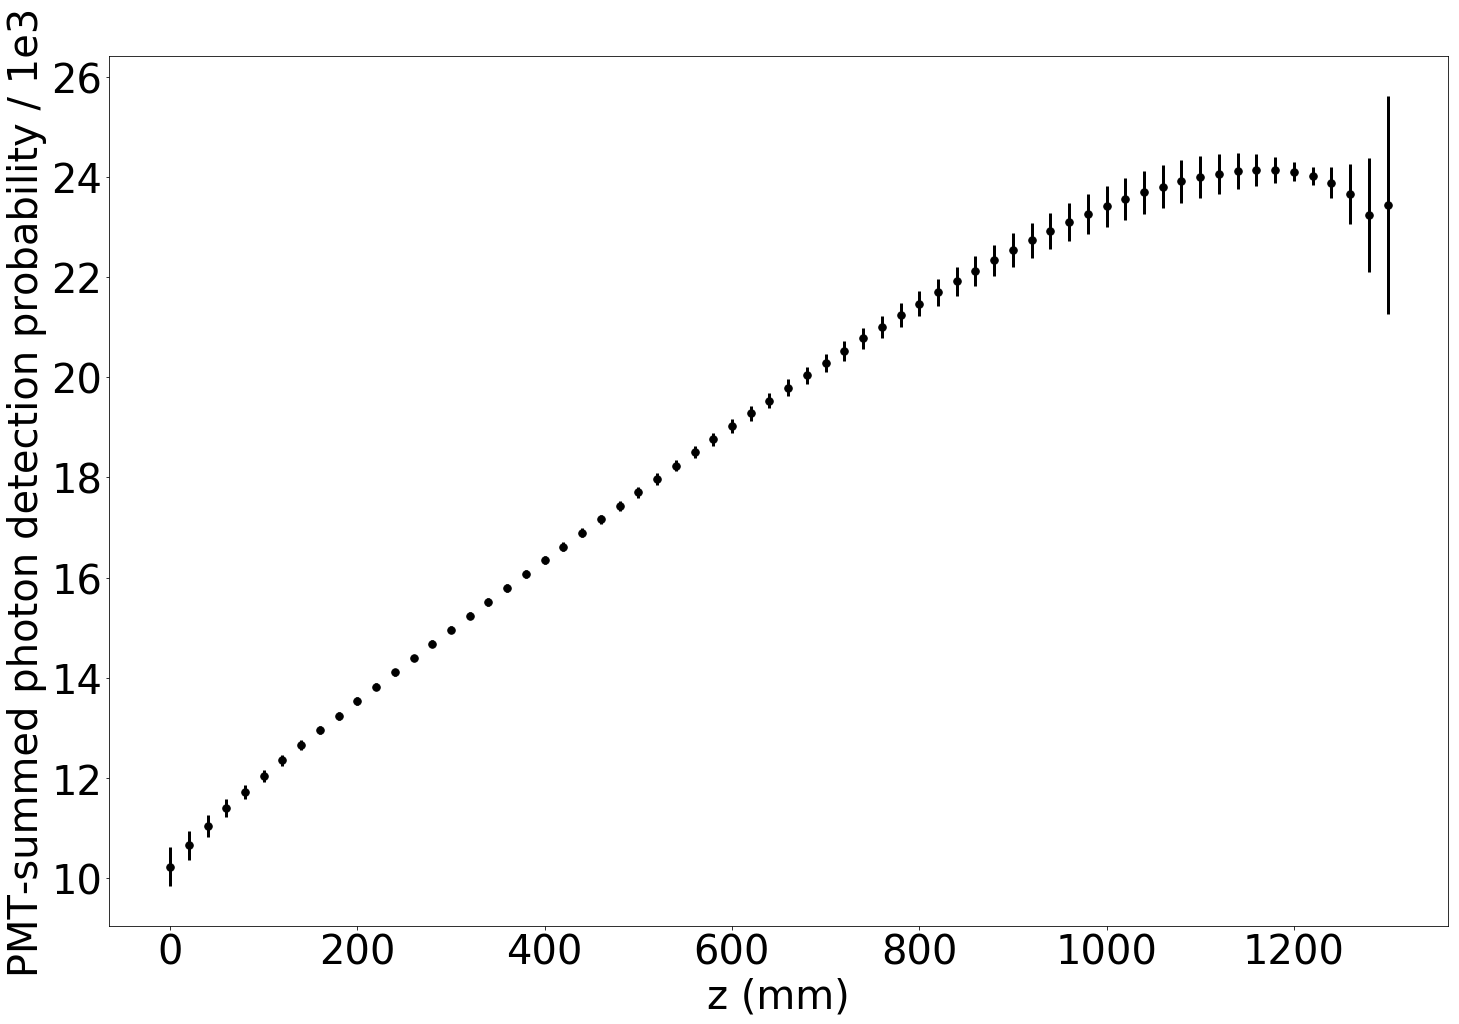

In [38]:
df       = df_table.copy()
df.Prob *= 1e3

zs      = []
probs   = []
uncerts = []
for z, z_dat in df.groupby("Z"):
    xy_dat  = z_dat.groupby(["X", "Y"])
    prob    = np.average(xy_dat.Prob.sum())
    uncert  = np.std    (xy_dat.Prob.sum())# / len(pmt)**0.5

    zs     .append(z)
    probs  .append(prob)
    uncerts.append(uncert)

plt.errorbar(zs, probs, uncerts, fmt=".k")
#plt.ylim(gb.Prob.min().min() * 0.9, gb.Prob.max().max() * 1.1)
plt.xlabel("z (mm)")
plt.ylabel("PMT-summed photon detection probability / 1e3")
save("next100_s1_sum_vs_z.png")

In [39]:
pmt

X         Y  Corona           R       Phi
SensorID                                                  
0           0.0000  110.0000       0  110.000000  1.570796
1          95.2628   55.0000       0  110.000005  0.523599
2          95.2628  -55.0000       0  110.000005 -0.523599
3           0.0000 -110.0000       0  110.000000 -1.570796
4         -95.2628  -55.0000       0  110.000005 -2.617994
5         -95.2628   55.0000       0  110.000005  2.617994
6           0.0000  220.0000       1  220.000000  1.570796
7         110.0000  190.5260       1  220.000356  1.047198
8         190.5260  110.0000       1  220.000356  0.523598
9         220.0000    0.0000       1  220.000000  0.000000
10        190.5260 -110.0000       1  220.000356 -0.523598
11        110.0000 -190.5260       1  220.000356 -1.047198
12          0.0000 -220.0000       1  220.000000 -1.570796
13       -110.0000 -190.5260       1  220.000356 -2.094394
14       -190.5260 -110.0000       1  220.000356 -2.617995
15       -220.0000    0.0000       1  220.000000  3.141593
16       -190.5260  110.0000       1  220.000356  2.617995
17       -110.0000  190.5260       1  220.000356  2.094394
18          0.0000  330.0000       2  330.000000  1.570796
19        112.8670  310.0990       2  330.000530  1.221730
20        212.1200  252.7950       2  330.000313  0.872665
21        285.7880  165.0000       2  329.999668  0.523599
22        324.9870   57.3039       2  330.000435  0.174533
23        324.9870  -57.3039       2  330.000435 -0.174533
24        285.7880 -165.0000       2  329.999668 -0.523599
25        212.1200 -252.7950       2  330.000313 -0.872665
26        112.8670 -310.0990       2  330.000530 -1.221730
27          0.0000 -330.0000       2  330.000000 -1.570796
28       -112.8670 -310.0990       2  330.000530 -1.919863
29       -212.1200 -252.7950       2  330.000313 -2.268928
30       -285.7880 -165.0000       2  329.999668 -2.617993
31       -324.9870  -57.3039       2  330.000435 -2.967060
32       -324.9870   57.3039       2  330.000435  2.967060
33       -285.7880  165.0000       2  329.999668  2.617993
34       -212.1200  252.7950       2  330.000313  2.268928
35       -112.8670  310.0990       2  330.000530  1.919863
36          0.0000  440.0000       3  440.000000  1.570796
37        113.8800  425.0070       3  439.999551  1.308998
38        220.0000  381.0510       3  439.999846  1.047197
39        311.1270  311.1270       3  440.000023  0.785398
40        381.0510  220.0000       3  439.999846  0.523599
41        425.0070  113.8800       3  439.999551  0.261799
42        440.0000    0.0000       3  440.000000  0.000000
43        425.0070 -113.8800       3  439.999551 -0.261799
44        381.0510 -220.0000       3  439.999846 -0.523599
45        311.1270 -311.1270       3  440.000023 -0.785398
46        220.0000 -381.0510       3  439.999846 -1.047197
47        113.8800 -425.0070       3  439.999551 -1.308998
48          0.0000 -440.0000       3  440.000000 -1.570796
49       -113.8800 -425.0070       3  439.999551 -1.832595
50       -220.0000 -381.0510       3  439.999846 -2.094395
51       -311.1270 -311.1270       3  440.000023 -2.356194
52       -381.0510 -220.0000       3  439.999846 -2.617994
53       -425.0070 -113.8800       3  439.999551 -2.879794
54       -440.0000    0.0000       3  440.000000  3.141593
55       -425.0070  113.8800       3  439.999551  2.879794
56       -381.0510  220.0000       3  439.999846  2.617994
57       -311.1270  311.1270       3  440.000023  2.356194
58       -220.0000  381.0510       3  439.999846  2.094395
59       -113.8800  425.0070       3  439.999551  1.832595

In [40]:
active.head()

X      Y       Z
PointID                      
0       -520.0 -520.0  1340.0
1       -520.0 -500.0  1340.0
2       -520.0 -480.0  1340.0
3       -520.0 -460.0  1340.0
4       -520.0 -440.0  1340.0

# Control plots

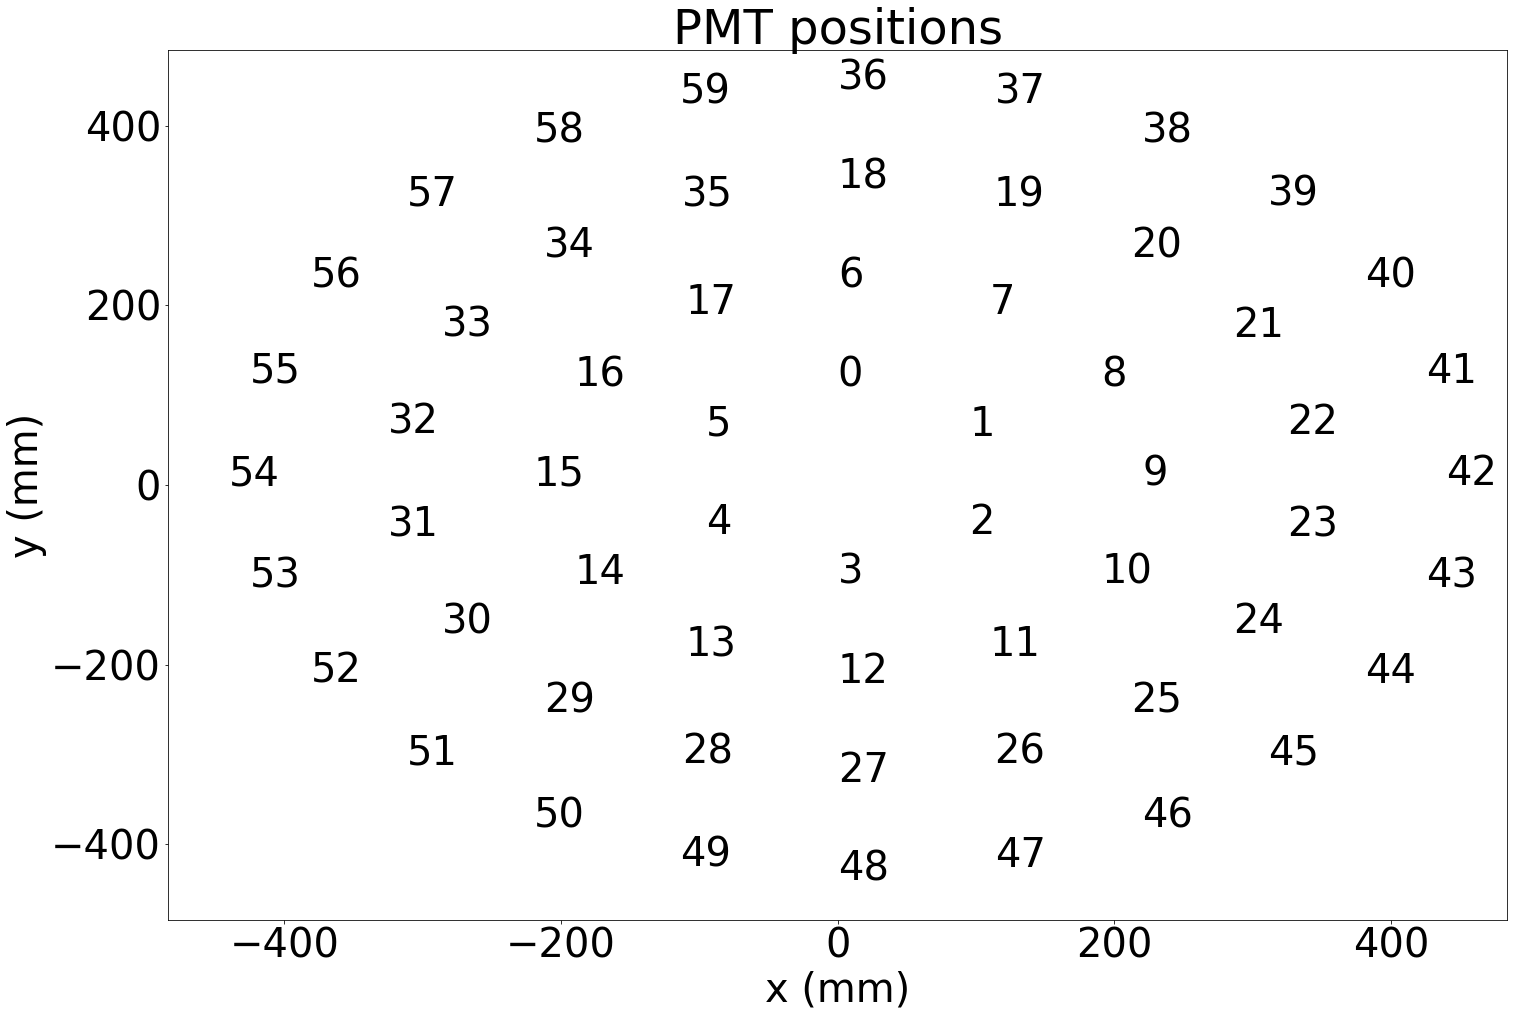

In [41]:
plt.scatter(pmt.X, pmt.Y, s=0)
for pmt_no, row in pmt.iterrows():
    plt.text(row.X, row.Y, str(int(pmt_no)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("PMT positions");

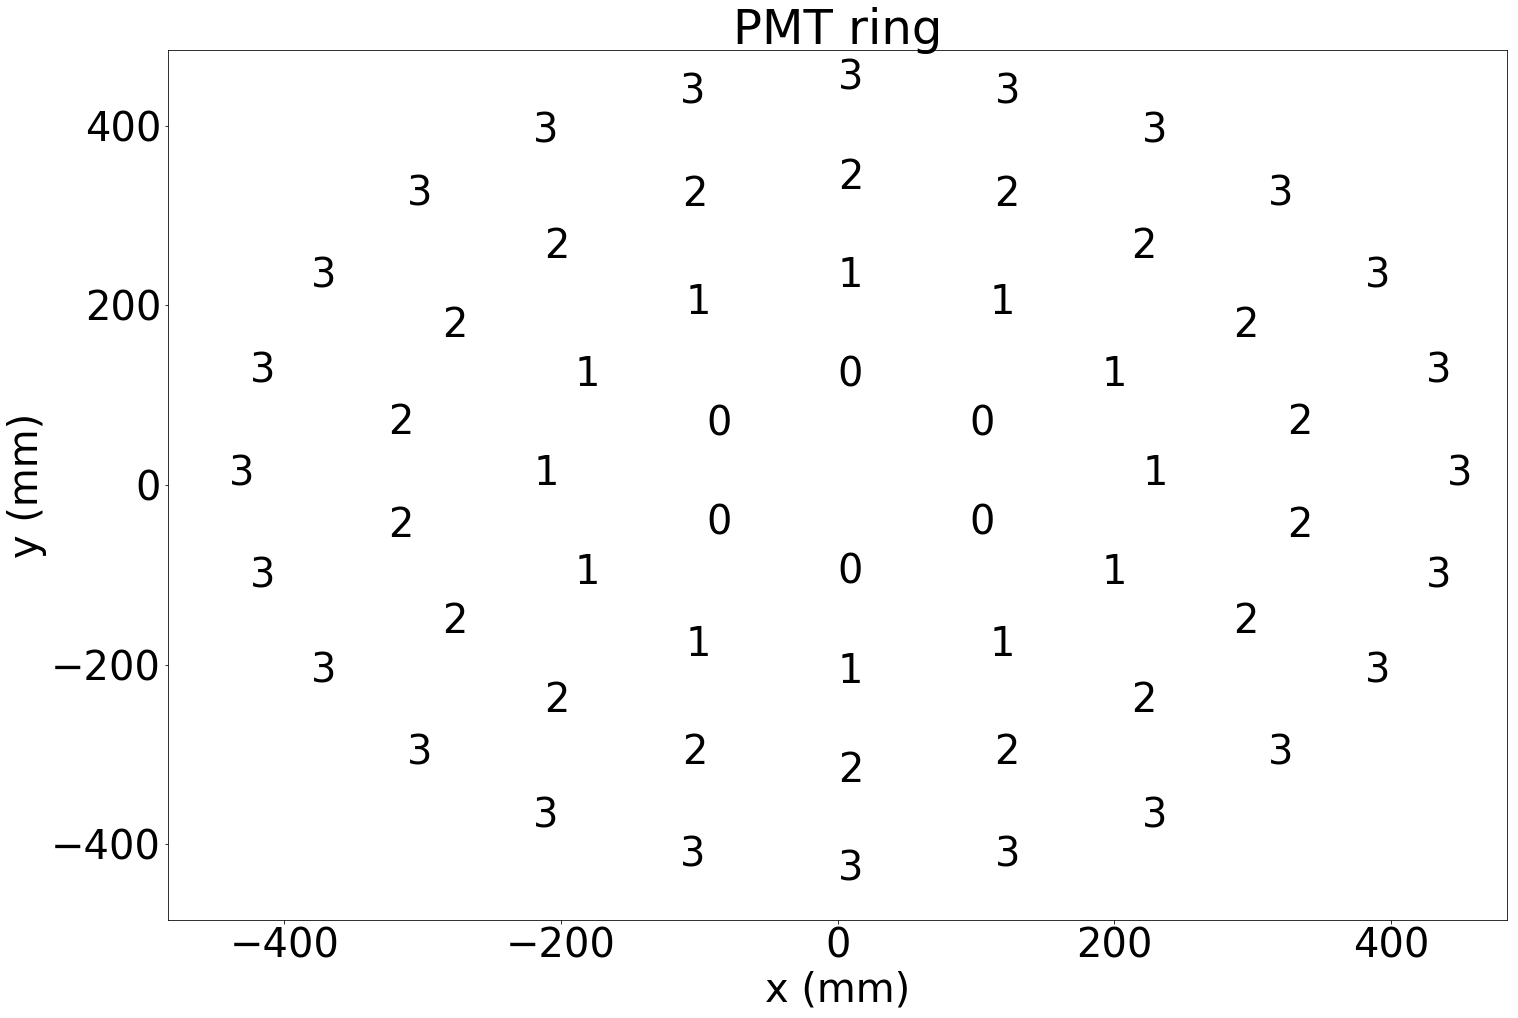

In [42]:
plt.scatter(pmt.X, pmt.Y, s=0)
for pmt_no, row in pmt.iterrows():
    plt.text(row.X, row.Y, str(int(row.Corona)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("PMT ring");

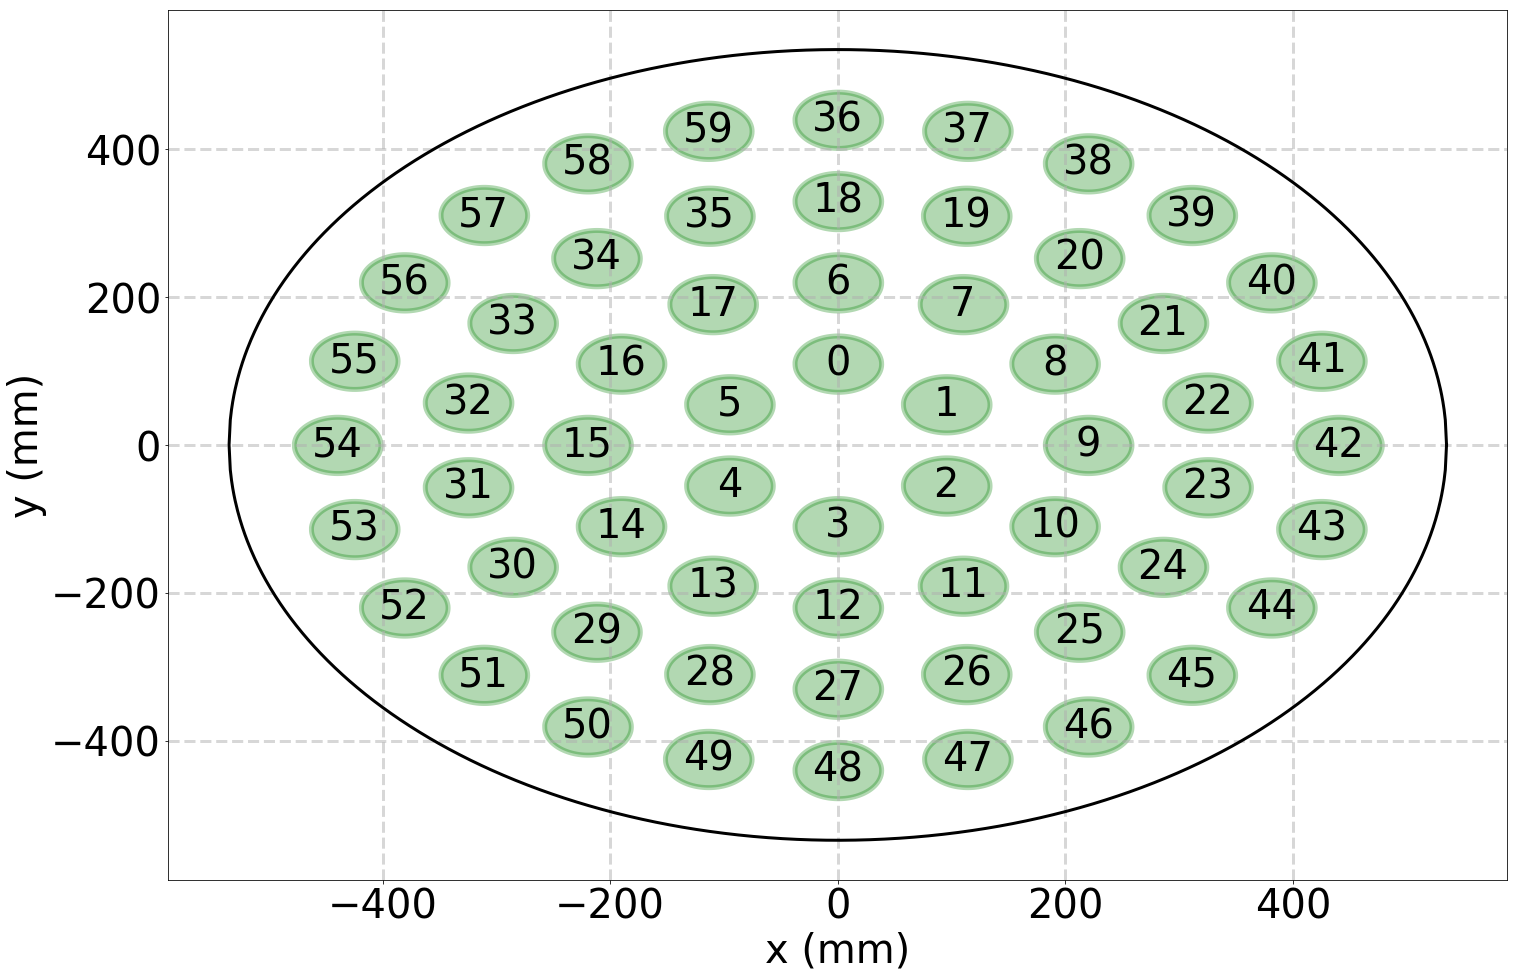

In [43]:
R = 535

x1 = np.linspace(+R, -R, 1000, endpoint=False)
y1 = +(R**2 - x1**2)**0.5
x2 = np.linspace(-R, +R, 1000)
y2 = -(R**2 - x2**2)**0.5

x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
plt.plot(x, y, "k", lw=3)

#plt.plot([-R, R], [ 0, 0], "r")
#plt.plot([ 0, 0], [-R, R], "r")

for pmt_no, row in pmt.iterrows():
    r  = 3 * 25.4 / 2
    x1 = np.linspace(+r, -r, 1000, endpoint=False)
    y1 = row.Y + (r**2 - x1**2)**0.5
    x2 = np.linspace(-r, +r, 1000)
    y2 = row.Y - (r**2 - x2**2)**0.5

#    x = np.concatenate([x1, x2]) + row.X
#    y = np.concatenate([y1, y2])
#    plt.plot(x, y, "g", lw=2)
#    plt.fill_between(x1 + row.X, y2, y1, facecolor="None", hatch="x", edgecolor="m", lw=5)
    plt.fill_between(x1 + row.X, y2, y1, facecolor="g", edgecolor="g", lw=5, alpha=0.3)
    plt.text(row.X, row.Y, str(int(pmt_no)),
             horizontalalignment="center",
             verticalalignment="center")

plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

plt.grid()

save("next100_pmt_positions.png")

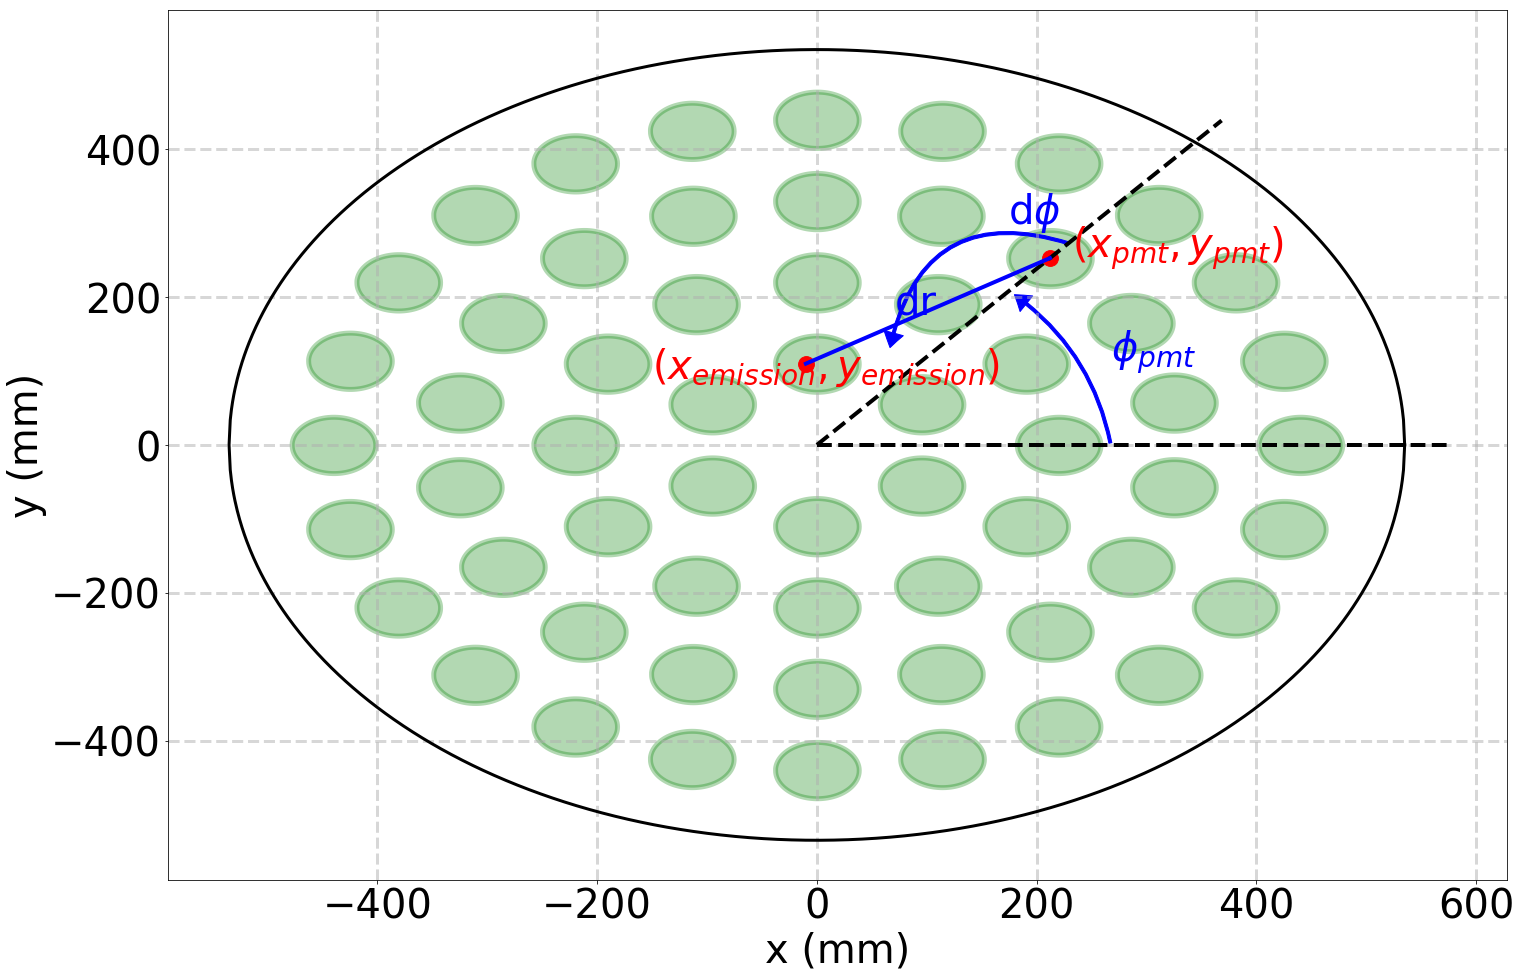

In [44]:
R = 535

x1 = np.linspace(+R, -R, 1000, endpoint=False)
y1 = +(R**2 - x1**2)**0.5
x2 = np.linspace(-R, +R, 1000)
y2 = -(R**2 - x2**2)**0.5

x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
plt.plot(x, y, "k", lw=3)

for pmt_no, row in pmt.iterrows():
    r  = 3 * 25.4 / 2
    x1 = np.linspace(+r, -r, 1000, endpoint=False)
    y1 = row.Y + (r**2 - x1**2)**0.5
    x2 = np.linspace(-r, +r, 1000)
    y2 = row.Y - (r**2 - x2**2)**0.5

    plt.fill_between(x1 + row.X, y2, y1, facecolor="g", edgecolor="g", lw=5, alpha=0.3)
    
pmt0 = 20
phi0 = pmt.Phi[pmt0]
x0, y0 = pmt.X[pmt0], pmt.Y[pmt0]
xr, yr = (R+r) * np.cos(phi0), (R+r) * np.sin(phi0)
x1, y1 = -10, 110

plt.plot   ([ 0, R+r], [ 0,  0], "k--", lw=  4) # y = 0
plt.plot   ([ 0,  xr], [ 0, yr], "k--", lw=  4) # y = tan(phi0) * x
plt.plot   ([x0,  x1], [y0, y1], "b-" , lw=  4) # from pmt to point
plt.scatter([x0,  x1], [y0, y1], c="r", s =250) # from pmt to point

plt.text(x0 / 3  , y0 * 0.7, "dr", color="b")
plt.text(x0 + 20 , y0      , "($x_{pmt}, y_{pmt}$)", color="r")
plt.text(x1 - 140, y1 - 20 , "($x_{emission}, y_{emission}$)", color="r")

style      = "Simple,tail_width=3,head_width=20,head_length=15"
connection = "arc3,rad=.2"
arrowkw    = dict(connectionstyle = connection,
                  arrowstyle      = style,
                  color           = "b")
arrowphi0 = patches.FancyArrowPatch((R/2, 0), (R/3, R/2 * np.sin(phi0)), **arrowkw)
plt.gca().add_patch(arrowphi0)
plt.text(R / 2, R / 2 * np.sin(phi0/2), r"$\phi_{pmt}$", color="b")

style      = "Simple,tail_width=3,head_width=20,head_length=15"
connection = "arc3,rad=.55"
arrowkw    = dict(connectionstyle = connection,
                  arrowstyle      = style,
                  color           = "b")
arrowdphi = patches.FancyArrowPatch((x0 + r/2, y0 + r/2),
                                    (x1 + r*2, y1 + r/2), **arrowkw)
plt.gca().add_patch(arrowdphi)
plt.text(x0 - r, y0 + r*1.25, "d$\phi$", color="b")


plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.grid()

save("next100_s1_parametrization_coordinates_definition.png")

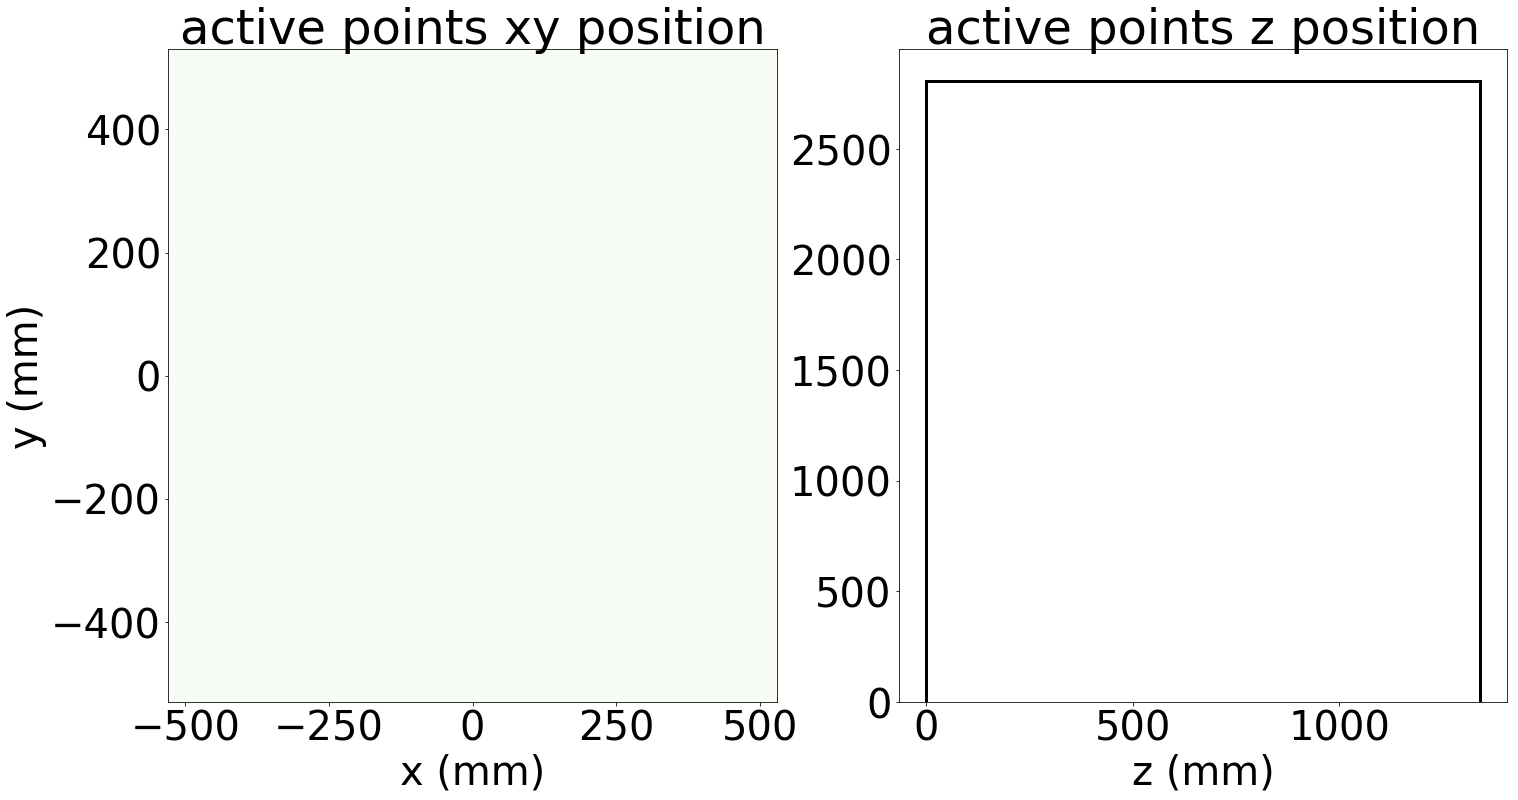

In [52]:
xy_binning = (np.arange(np.min(active.X) - 10, np.max(active.X) + 20 + 1, 20),
              np.arange(np.min(active.Y) - 10, np.max(active.Y) + 20 + 1, 20))
z_binning = np.arange(np.min(active.Z) - 1e-5, np.max(active.Z) + 1 + 1e-5, 20)

plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.hist2d(active.X, active.Y, xy_binning, cmap="Greens")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("active points xy position")

plt.subplot(1, 2, 2)
plt.hist(active.Z, z_binning, histtype="step", color="k", lw=3)
plt.xlabel("z (mm)")
plt.title ("active points z position");

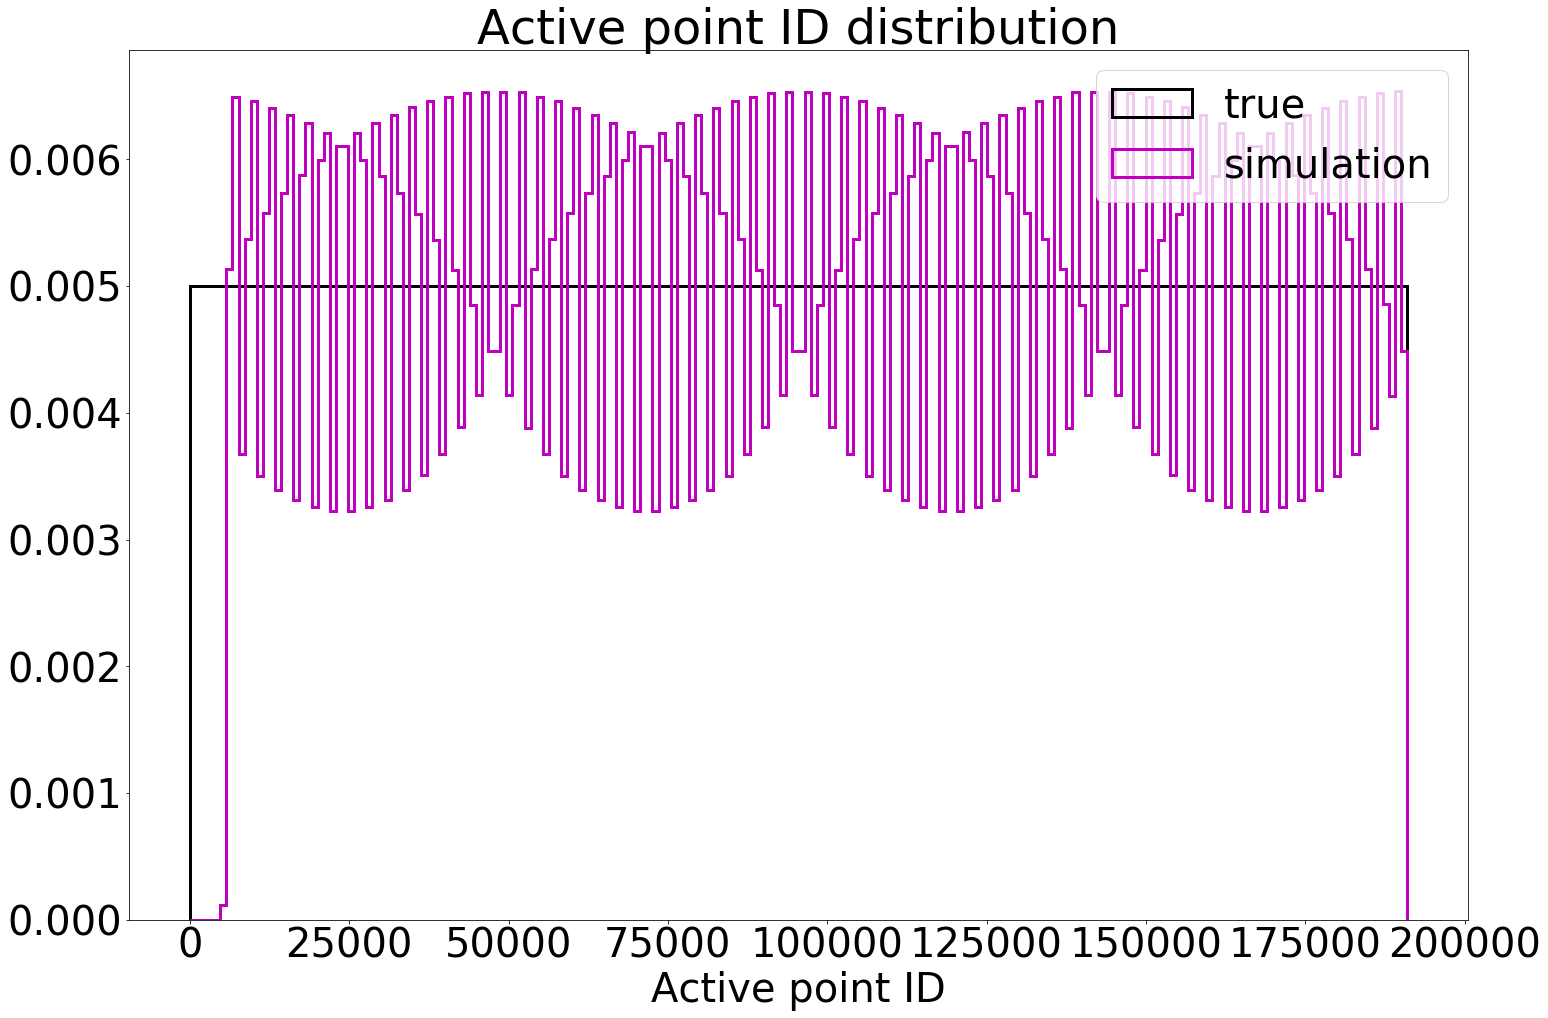

In [53]:
bins = np.linspace(active.index.min(), active.index.max(), 201)

weights = np.ones(len(active)) / len(active)
plt.hist(active.index, bins=bins, weights=weights, color="k", histtype="step", lw=3, label="true")

weights = np.ones(len(df_table)) / len(df_table)
plt.hist(df_table.PointID, bins=bins, weights=weights, color="m", histtype="step", lw=3, label="simulation")

plt.legend()
plt.xlabel("Active point ID")
plt.ylabel("")
plt.title ("Active point ID distribution");

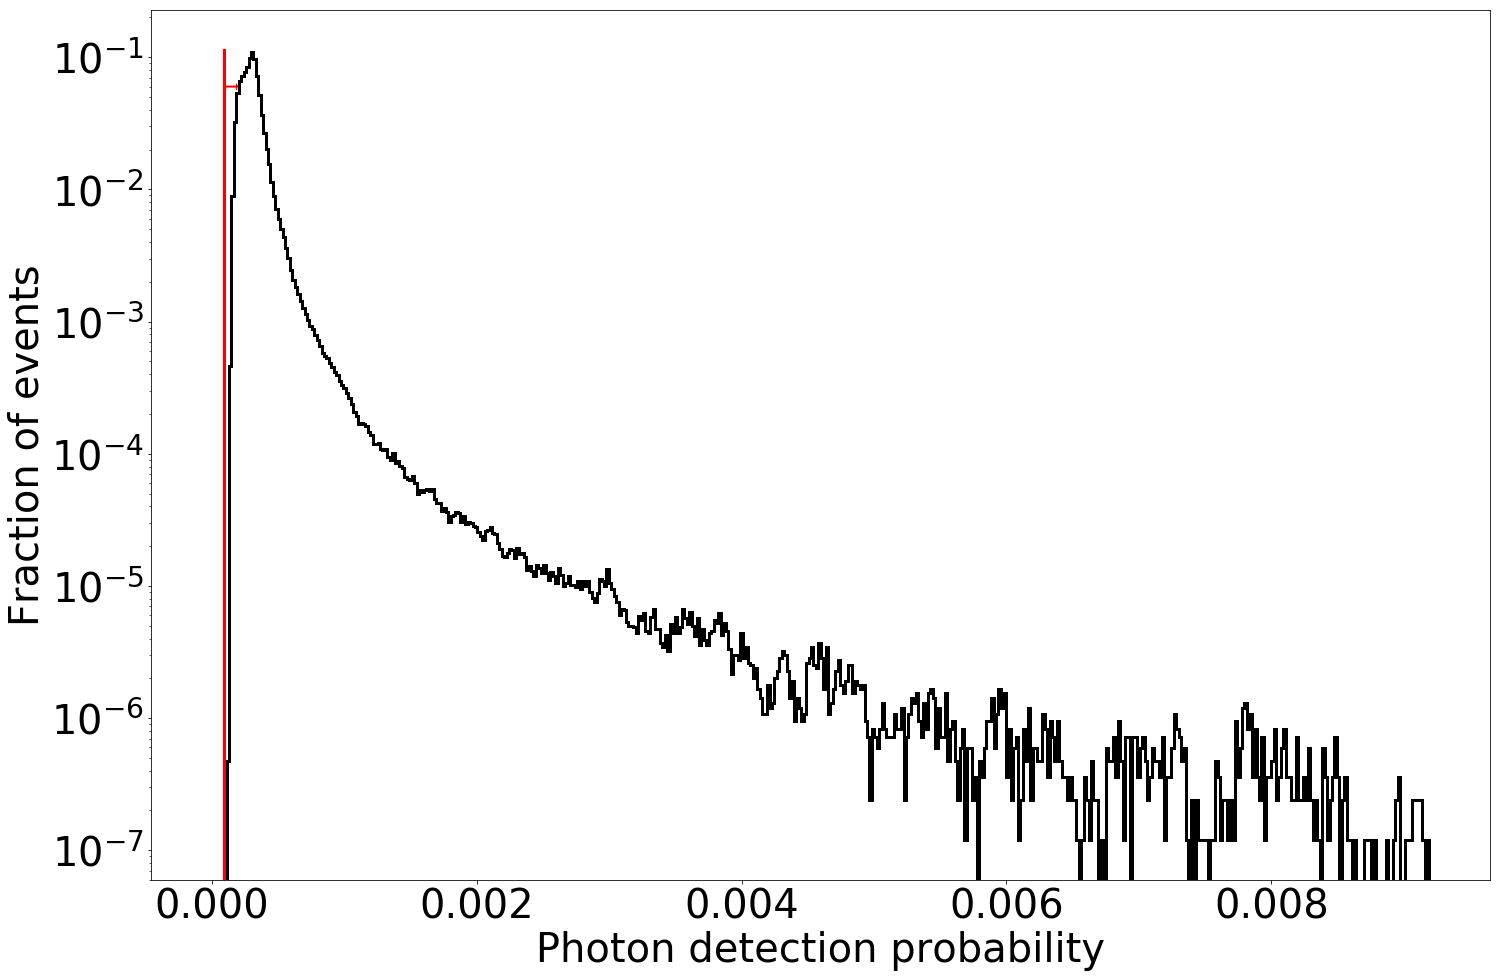

In [47]:
bins    = np.linspace(0, max(df_table.Prob), 501)
weights = np.ones(len(df_table)) / len(df_table)

y, x, _ = plt.hist(df_table.Prob, bins = bins, weights = weights, color="k", histtype="step", lw=3)

cut = x[:-1][y == 0][5]
plt.plot([cut, cut], plt.ylim(), "r-", lw=3)
plt.arrow(cut, np.mean(plt.ylim()), cut, 0,
          color="r", head_length=0.1*cut, head_width=0.1*np.mean(plt.ylim()))

plt.xlabel("Photon detection probability")
plt.ylabel("Fraction of events")
plt.yscale("log")

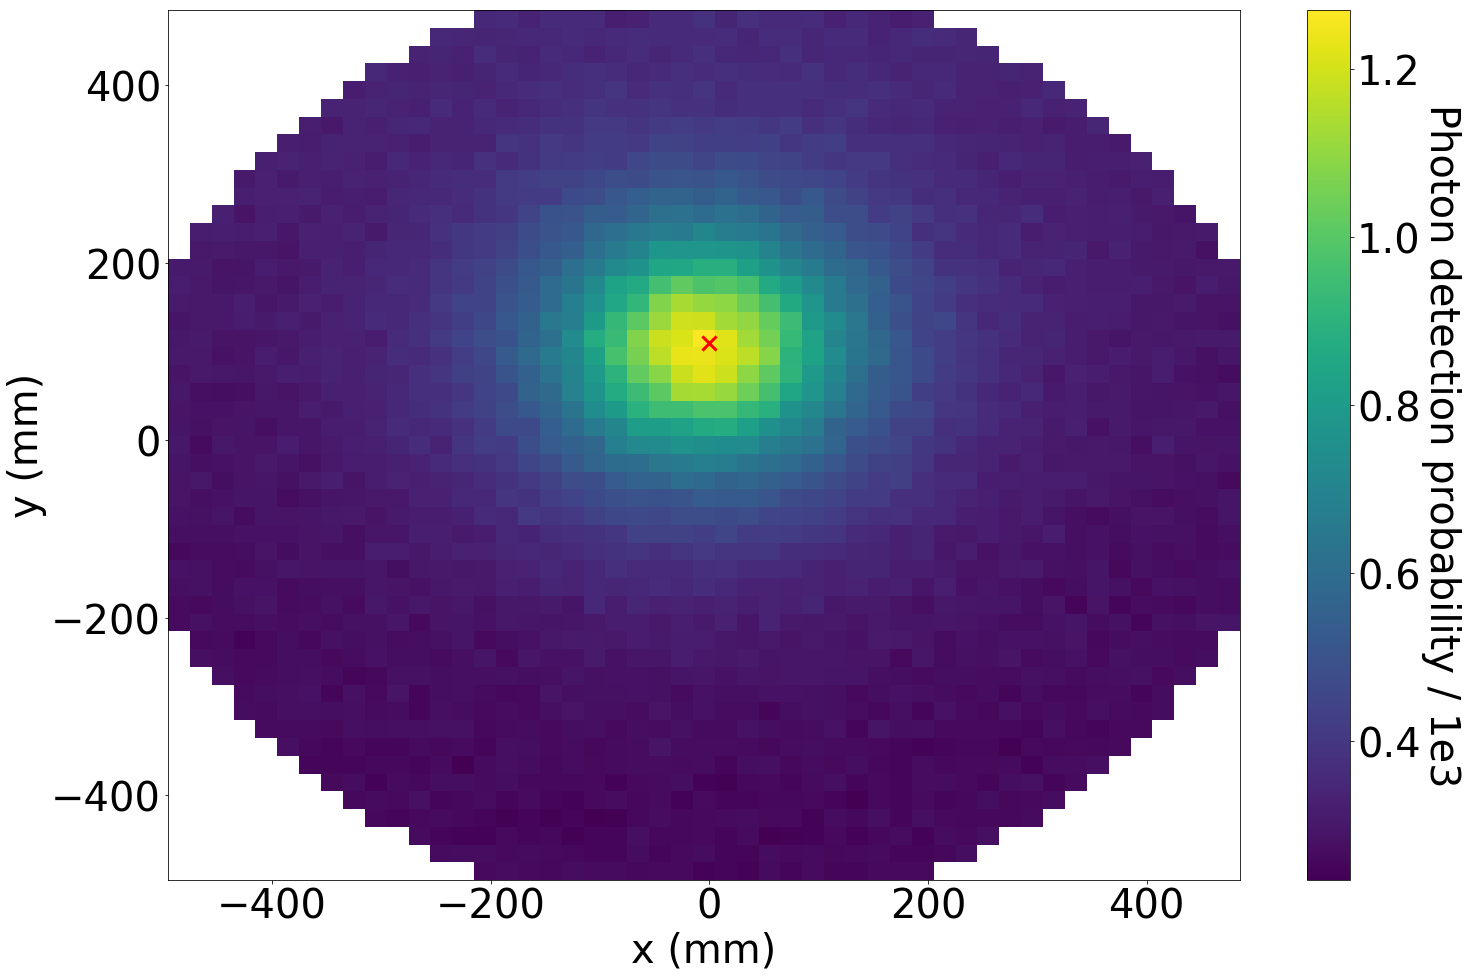

In [54]:
zh   = 1200
sel  = df_table.SensorID ==  0
sel &= df_table.Z        == zh

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 20),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 20))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

thispmt = pmt[pmt.index == 0]
plt.scatter(thispmt.X, thispmt.Y, s=200, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

save(f"next100_s1_table_inner_pmt_z_{zh}.png", dpi=200)

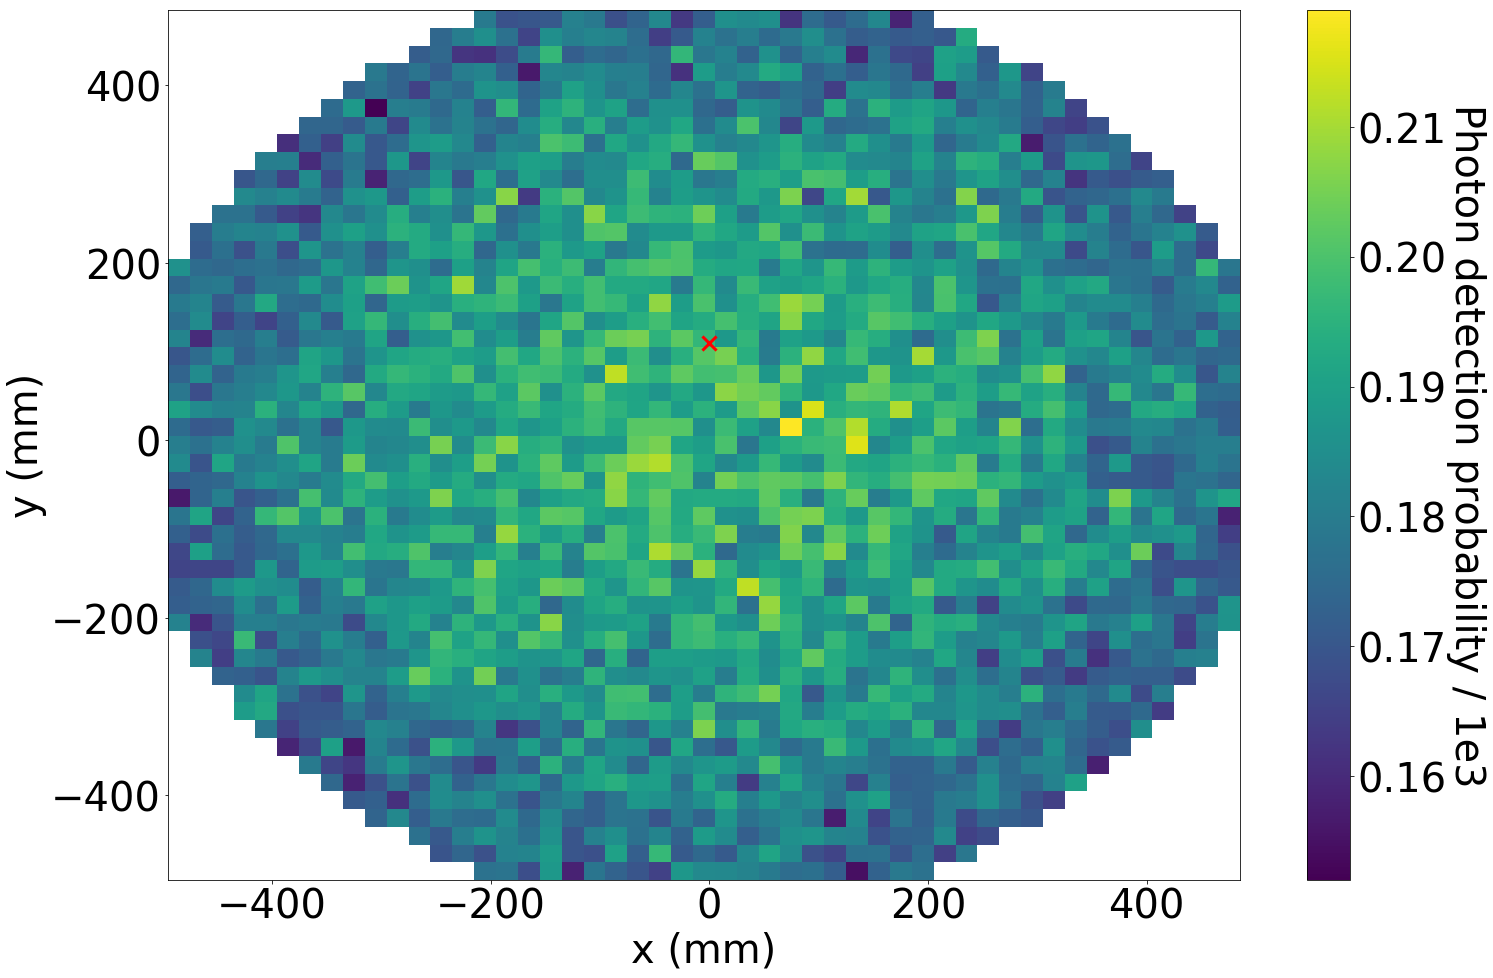

In [66]:
zl   = 0
sel  = df_table.SensorID ==  0
sel &= df_table.Z        == zl

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 20),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 20))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

thispmt = pmt[pmt.index == 0]
plt.scatter(thispmt.X, thispmt.Y, s=200, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

save(f"next100_s1_table_inner_pmt_z_{zl}.png", dpi=200)

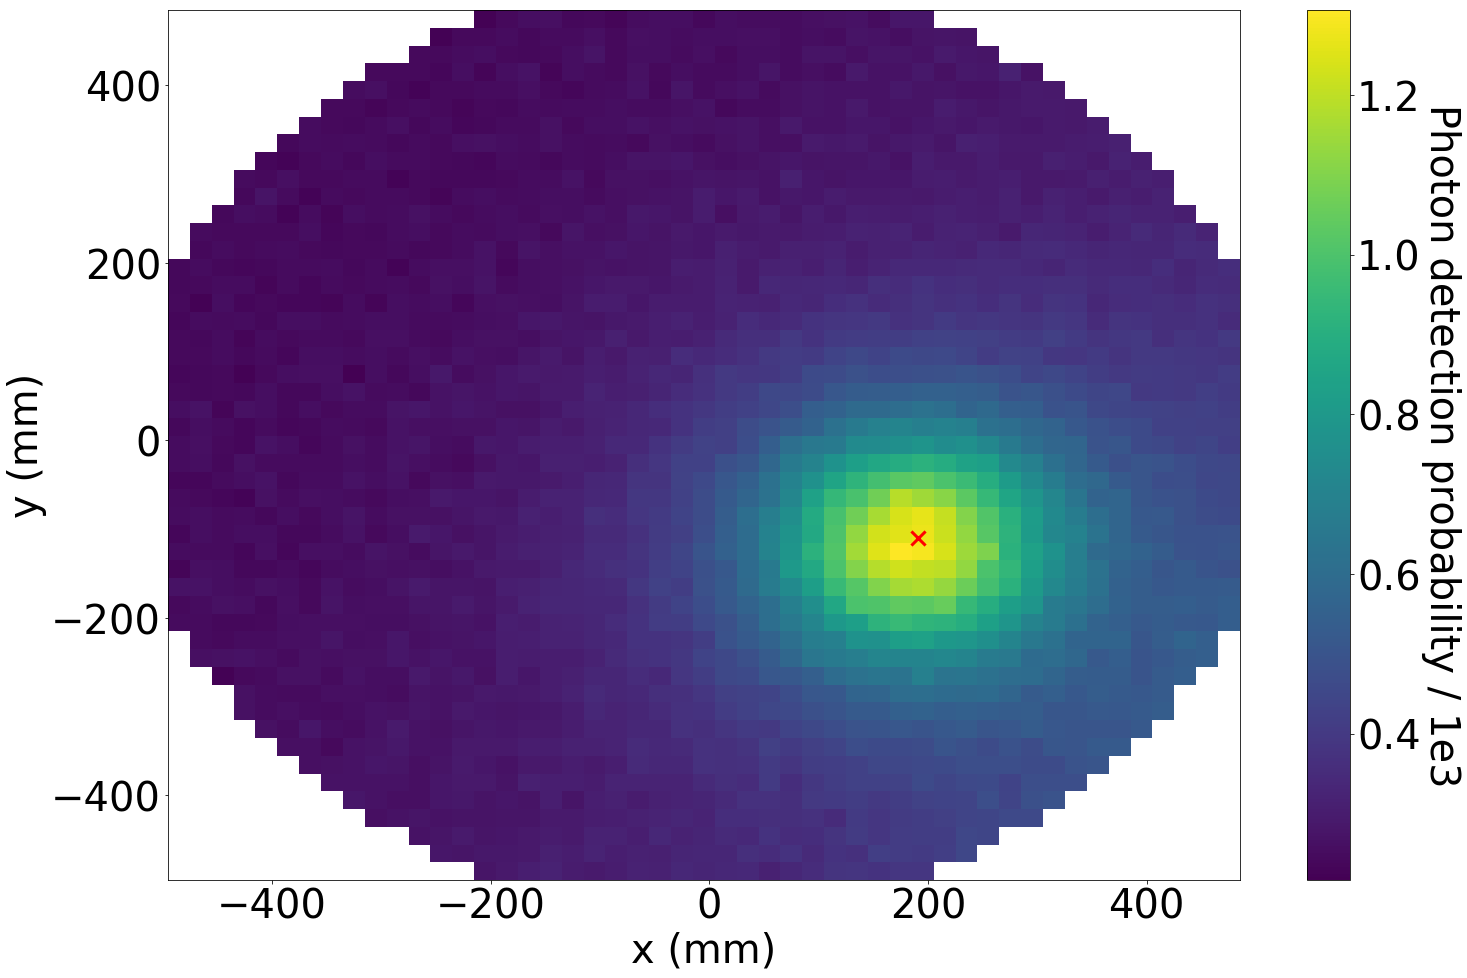

In [56]:
zh   = 1200
sel  = df_table.SensorID == 10
sel &= df_table.Z        == zh

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 20),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 20))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

thispmt = pmt[pmt.index == 10]
plt.scatter(thispmt.X, thispmt.Y, s=200, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

save(f"next100_s1_table_outer_pmt_z_{zh}.png", dpi=200)

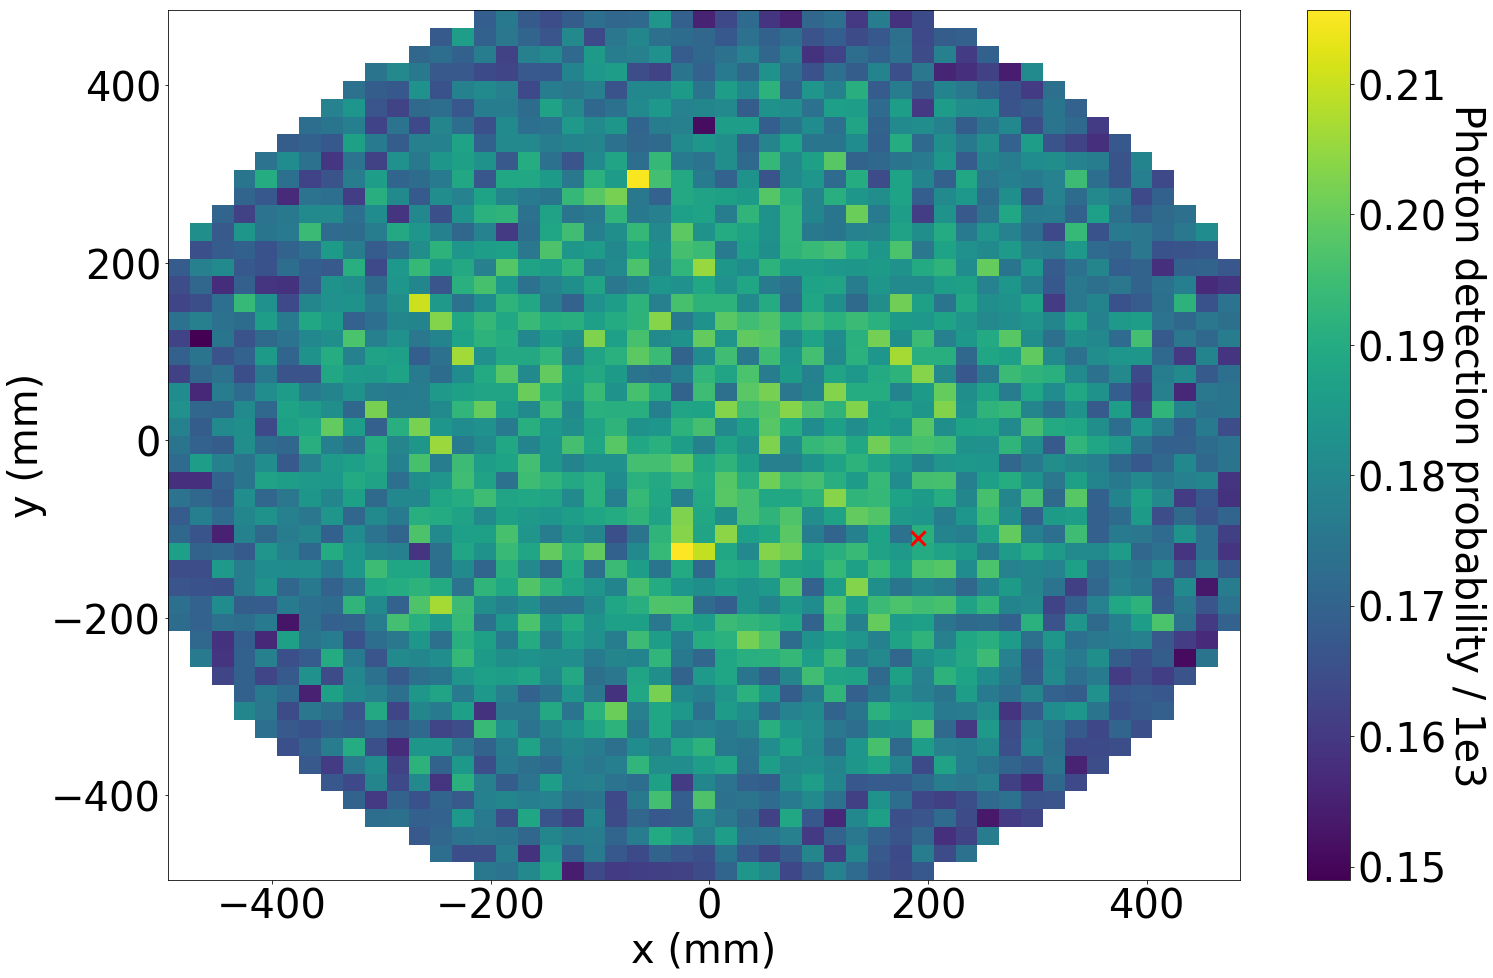

In [67]:
zl   = 0
sel  = df_table.SensorID == 10
sel &= df_table.Z        == zl

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 20),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 20))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

thispmt = pmt[pmt.index == 10]
plt.scatter(thispmt.X, thispmt.Y, s=200, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

save("next100_s1_table_outer_pmt_z_{zl}.png", dpi=200)

# PMT parametrization

In [68]:
print(f"Selecting data with P > {cut*1e5:.3f} · 10^{-5}")
df_table = df_table[df_table.Prob > cut]

Selecting data with P > 9.195 · 10^-5


In [69]:
dr_binning   = np.linspace(0, df_table.dR.max() * 1.001, 101)
dphi_binning = np.linspace(0, 2 * np.pi * 1.001, 101)
p_binning    = np.linspace(0, np.max(df_table.Prob) * 1.001, 101)

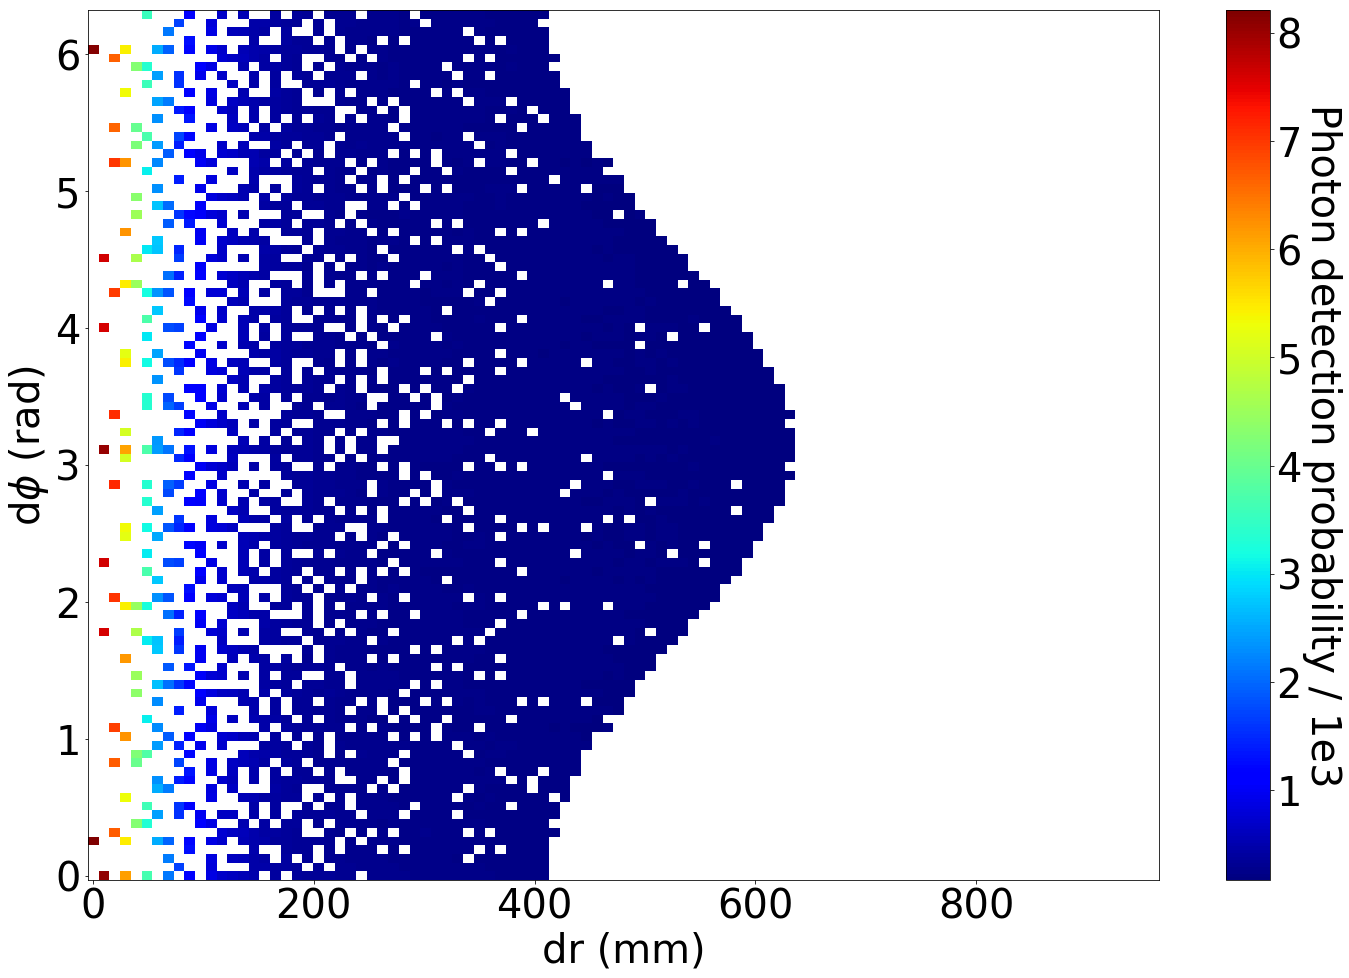

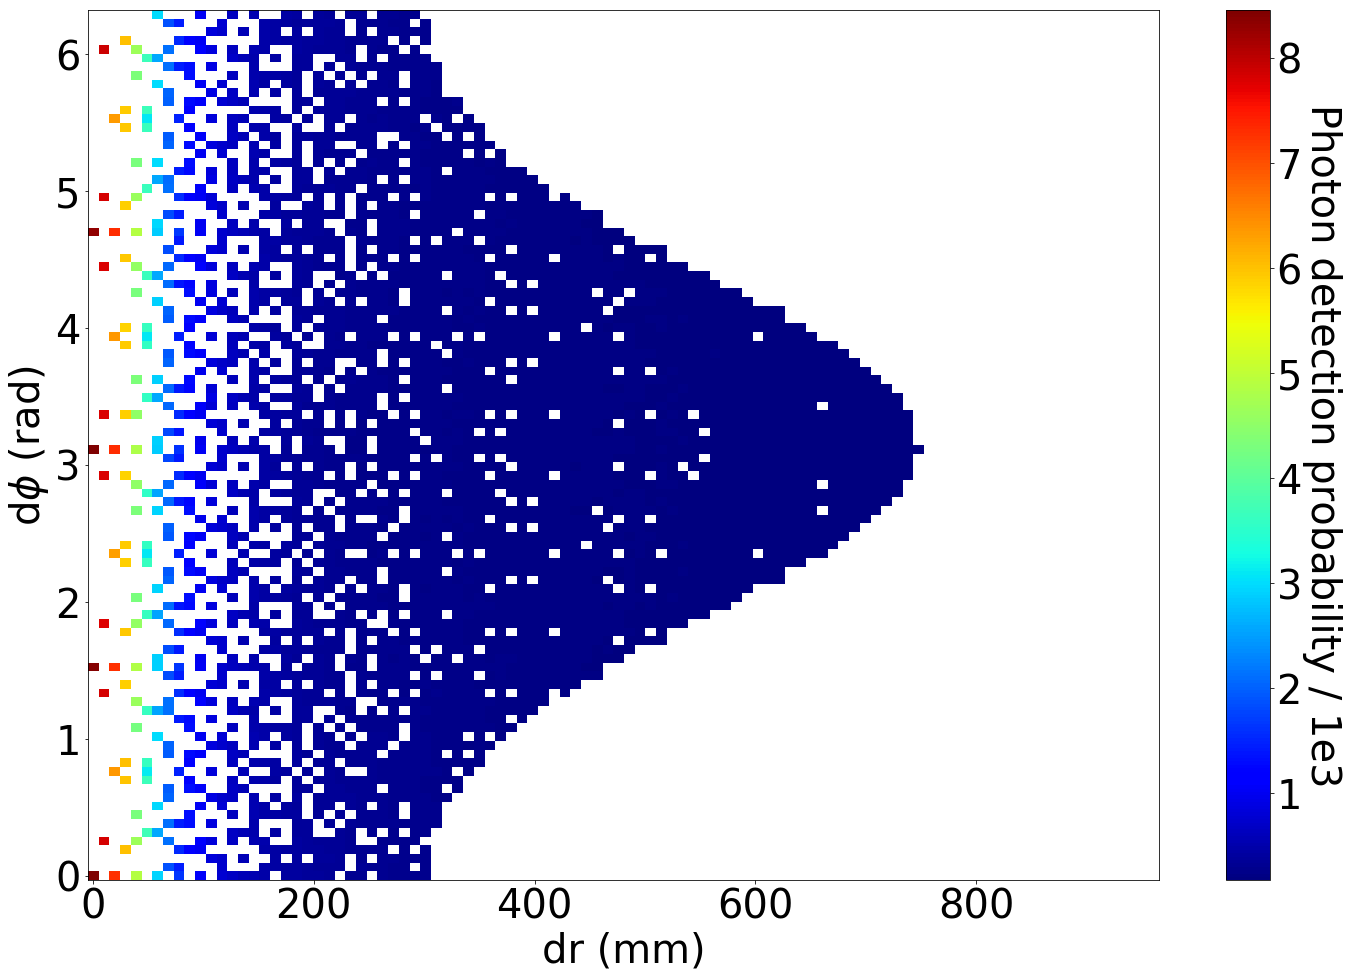

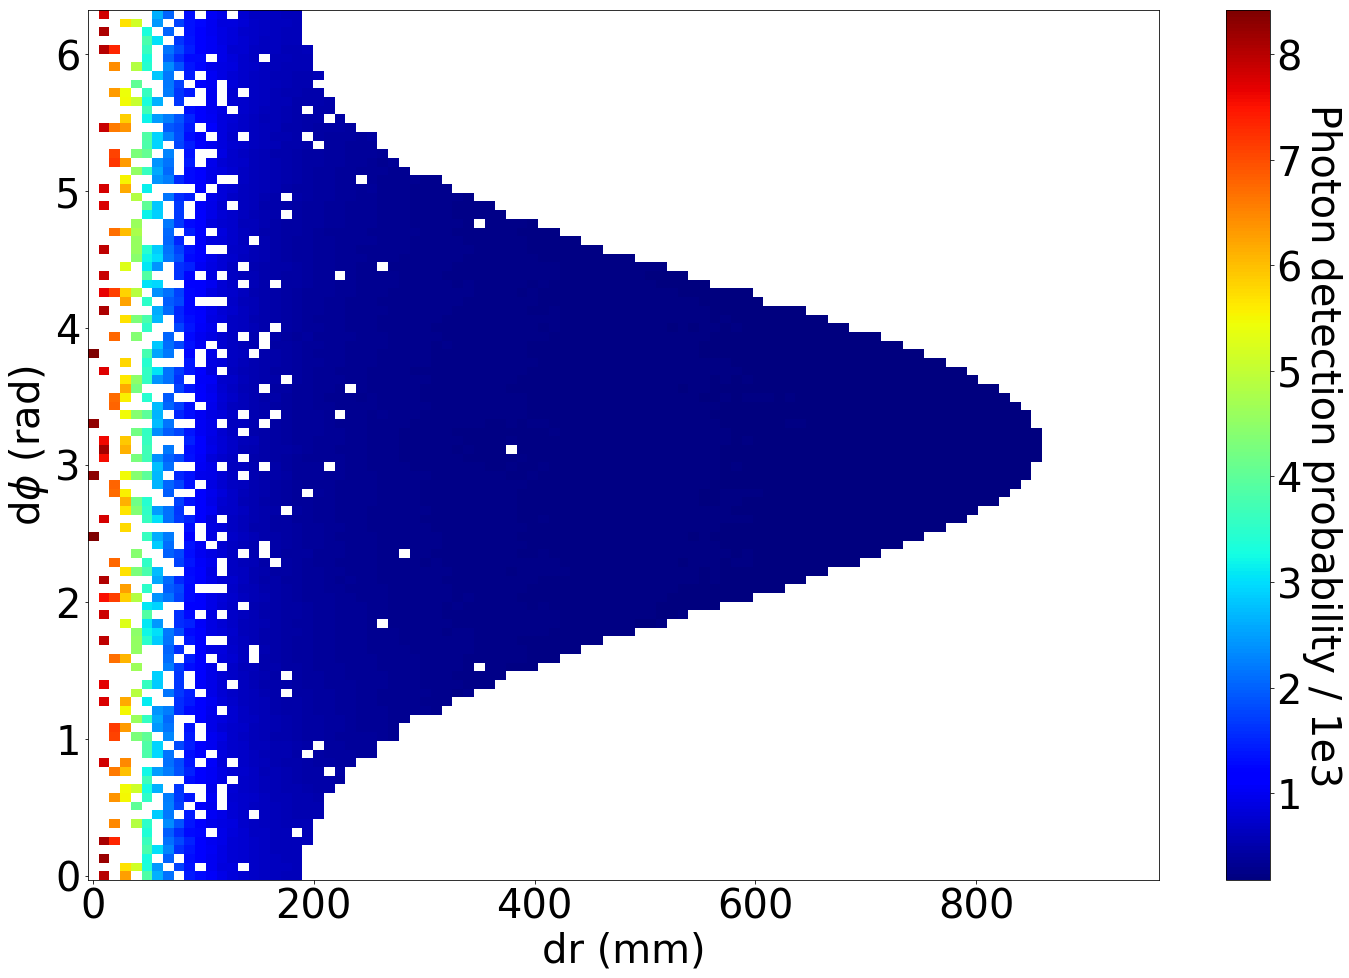

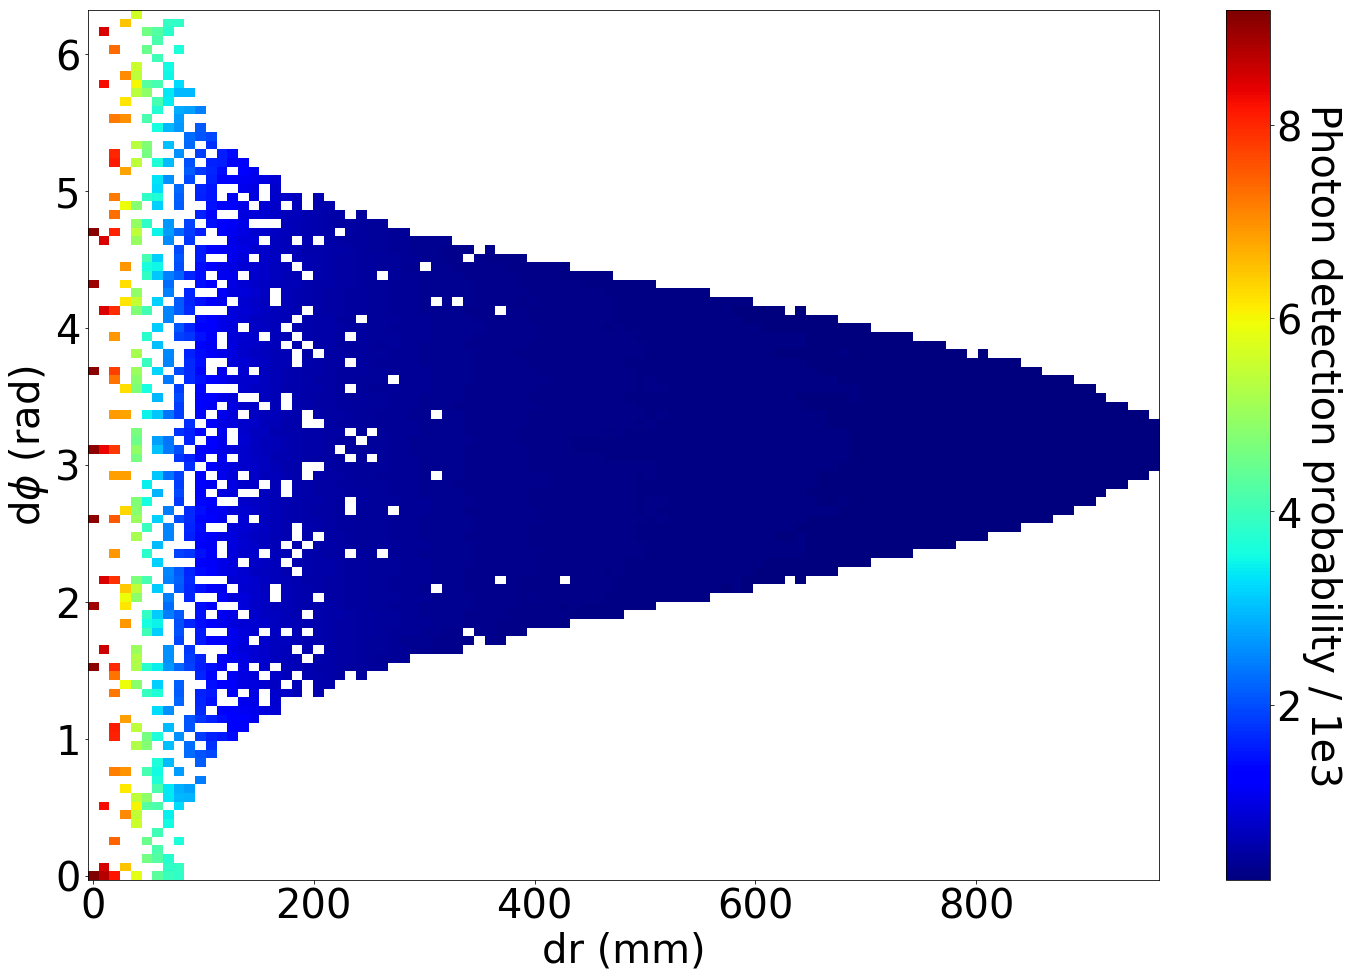

In [70]:
data = df_table[df_table.Z == z_max].copy()
data.Prob *= 1e3
for ring_no, ring in data.groupby("Ring"):
    plt.figure(figsize=(24, 16))
    x, y, z, u = fitf.profileXY(ring.dR, ring.dPhi, ring.Prob, dr_binning.size - 1, dphi_binning.size - 1,
                                xrange = (  dr_binning[0],   dr_binning[-1]),
                                yrange = (dphi_binning[0], dphi_binning[-1]))
    *_, cb = hstf.display_matrix(x, y, z, new_figure=False,
                                 cmap = "jet",
                                 cmin = 1e-8,
                                )
    plt.xlabel("dr (mm)")
    plt.ylabel("d$\phi$ (rad)")
    cb.set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

    name = "inner" if ring_no == 0 else "outer"
    save(f"next100_s1_dr_dphi_{name}_z_{z_max}.png")

In [71]:
dr_fit.head()

ring  dphi     z  dr_coeff         value        uncert
0     0     0  1280         0  5.334404e-03  1.110249e-05
1     0     0  1280         1 -7.019619e-05  2.186807e-07
2     0     0  1280         2  3.666996e-07  1.516812e-09
3     0     0  1280         3 -8.437215e-10  4.357269e-12
4     0     0  1280         4  7.156100e-13  4.416225e-15

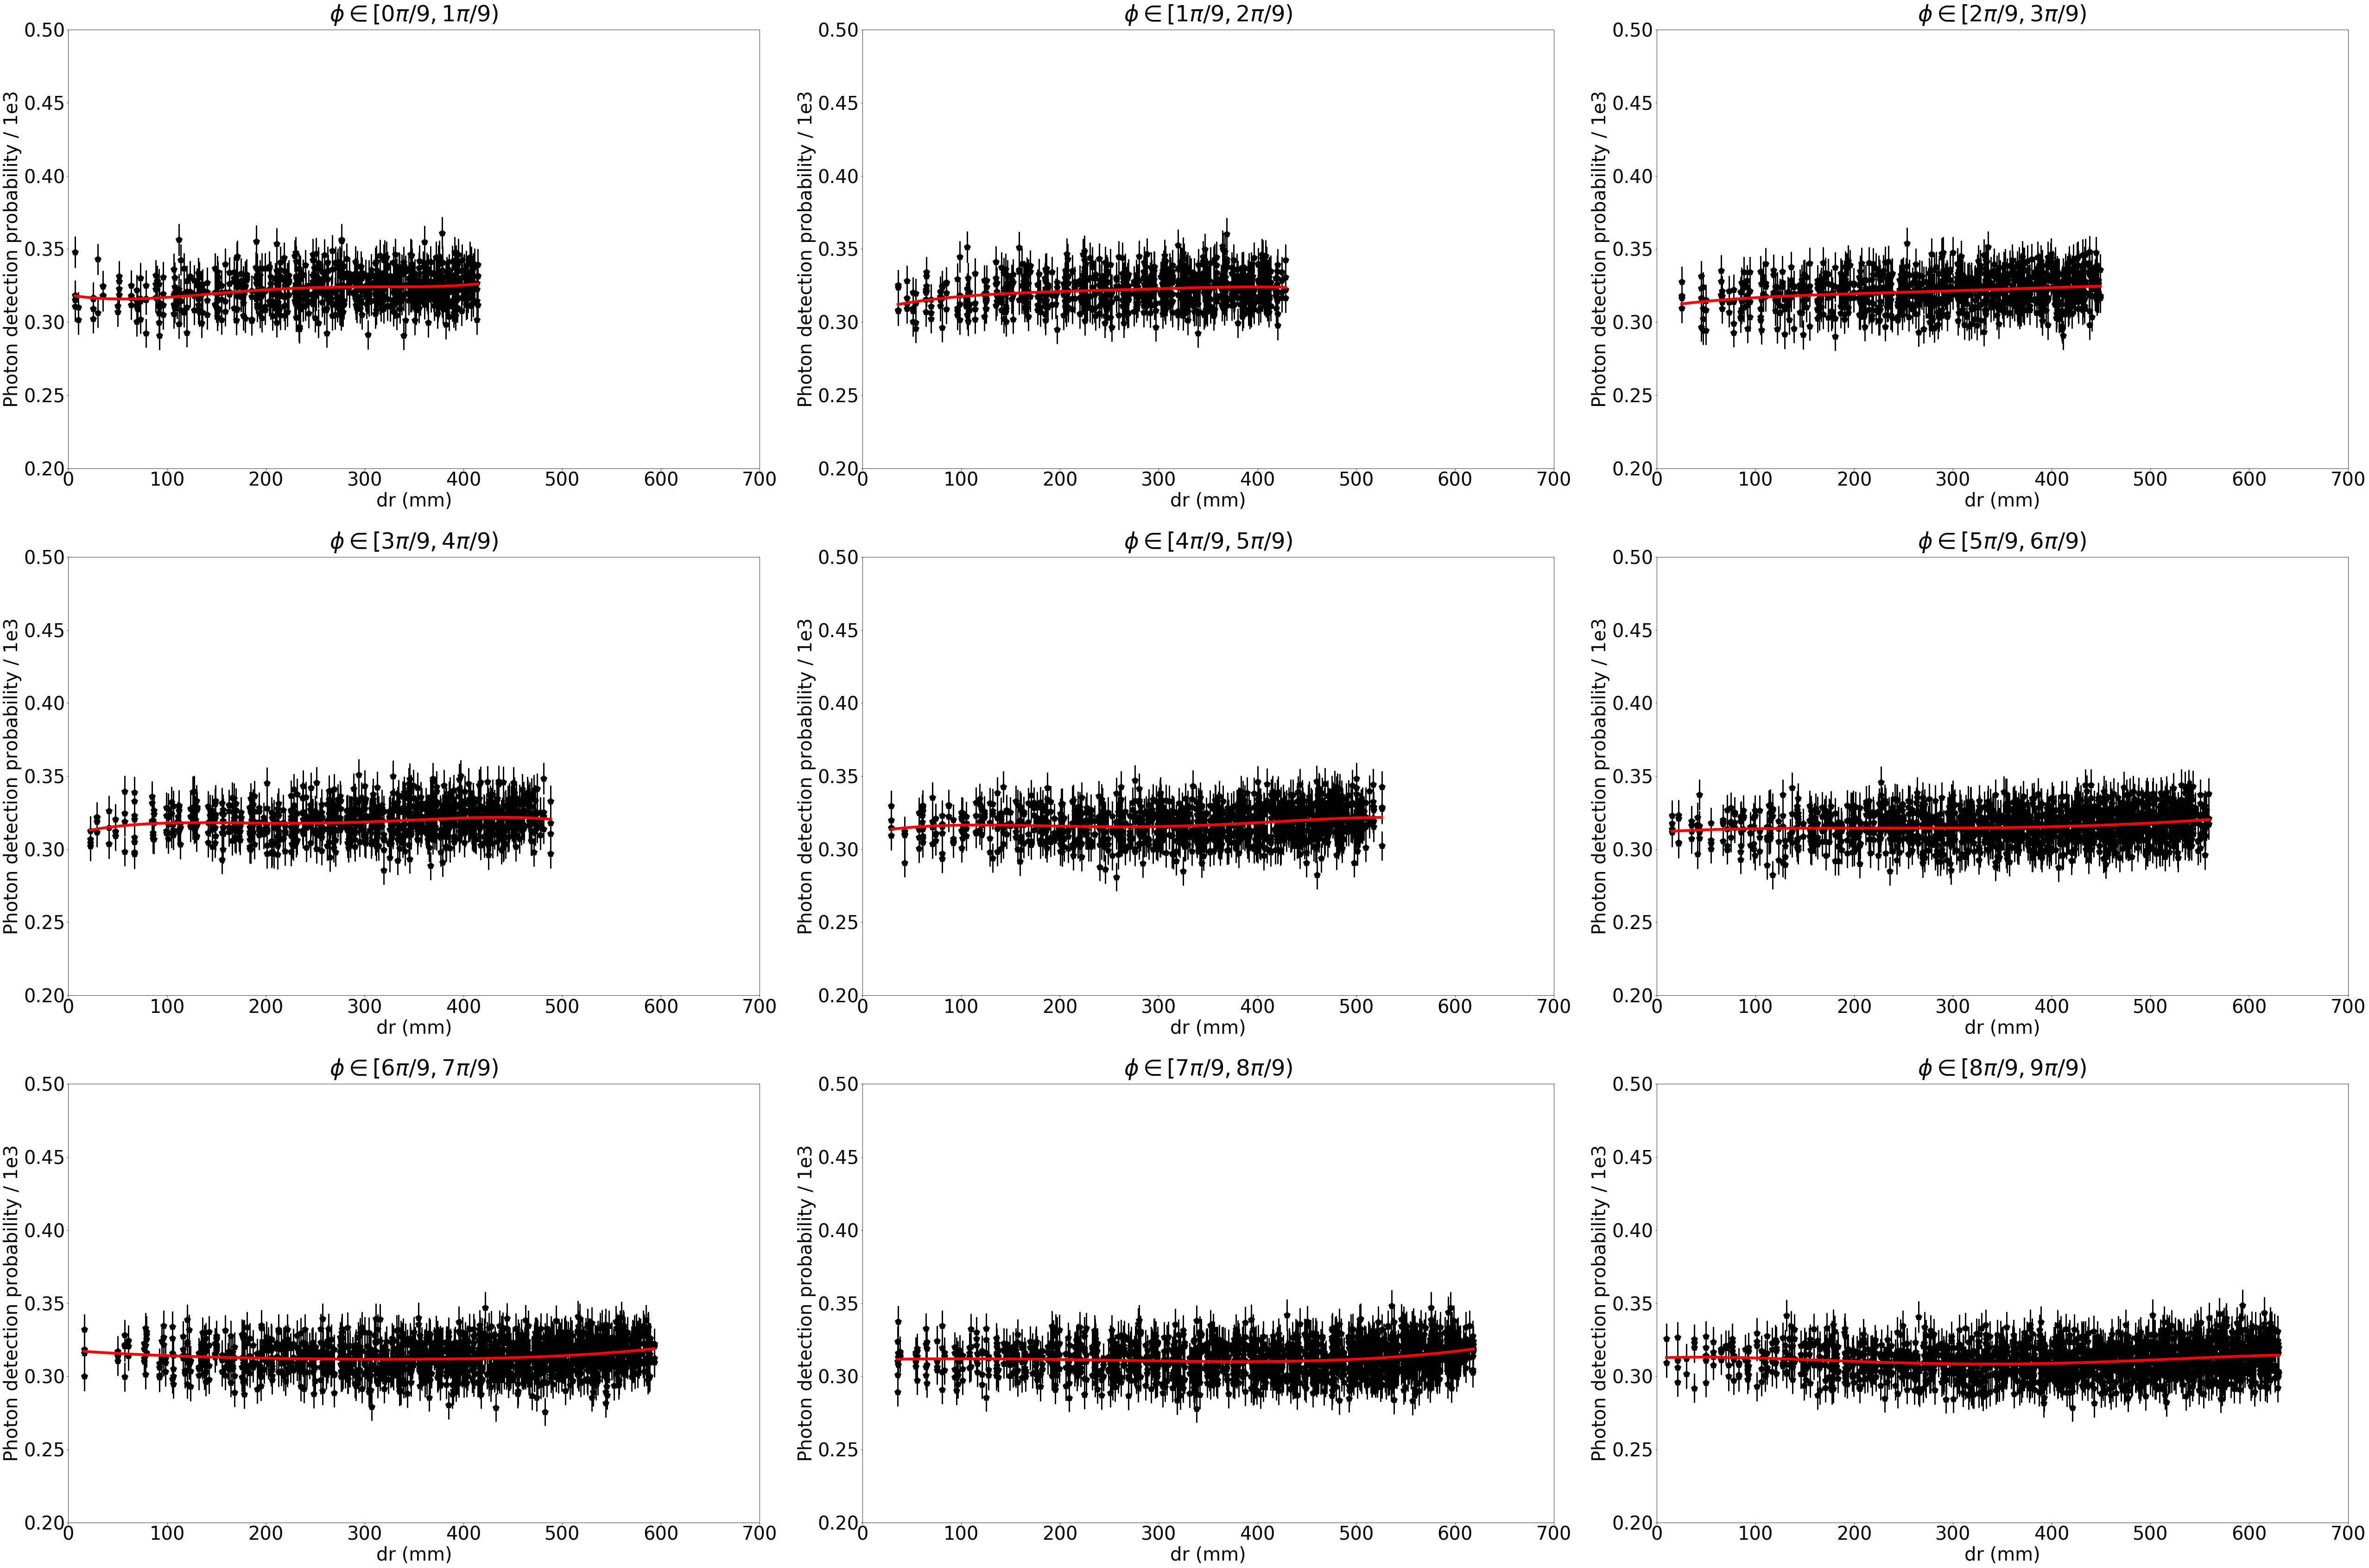

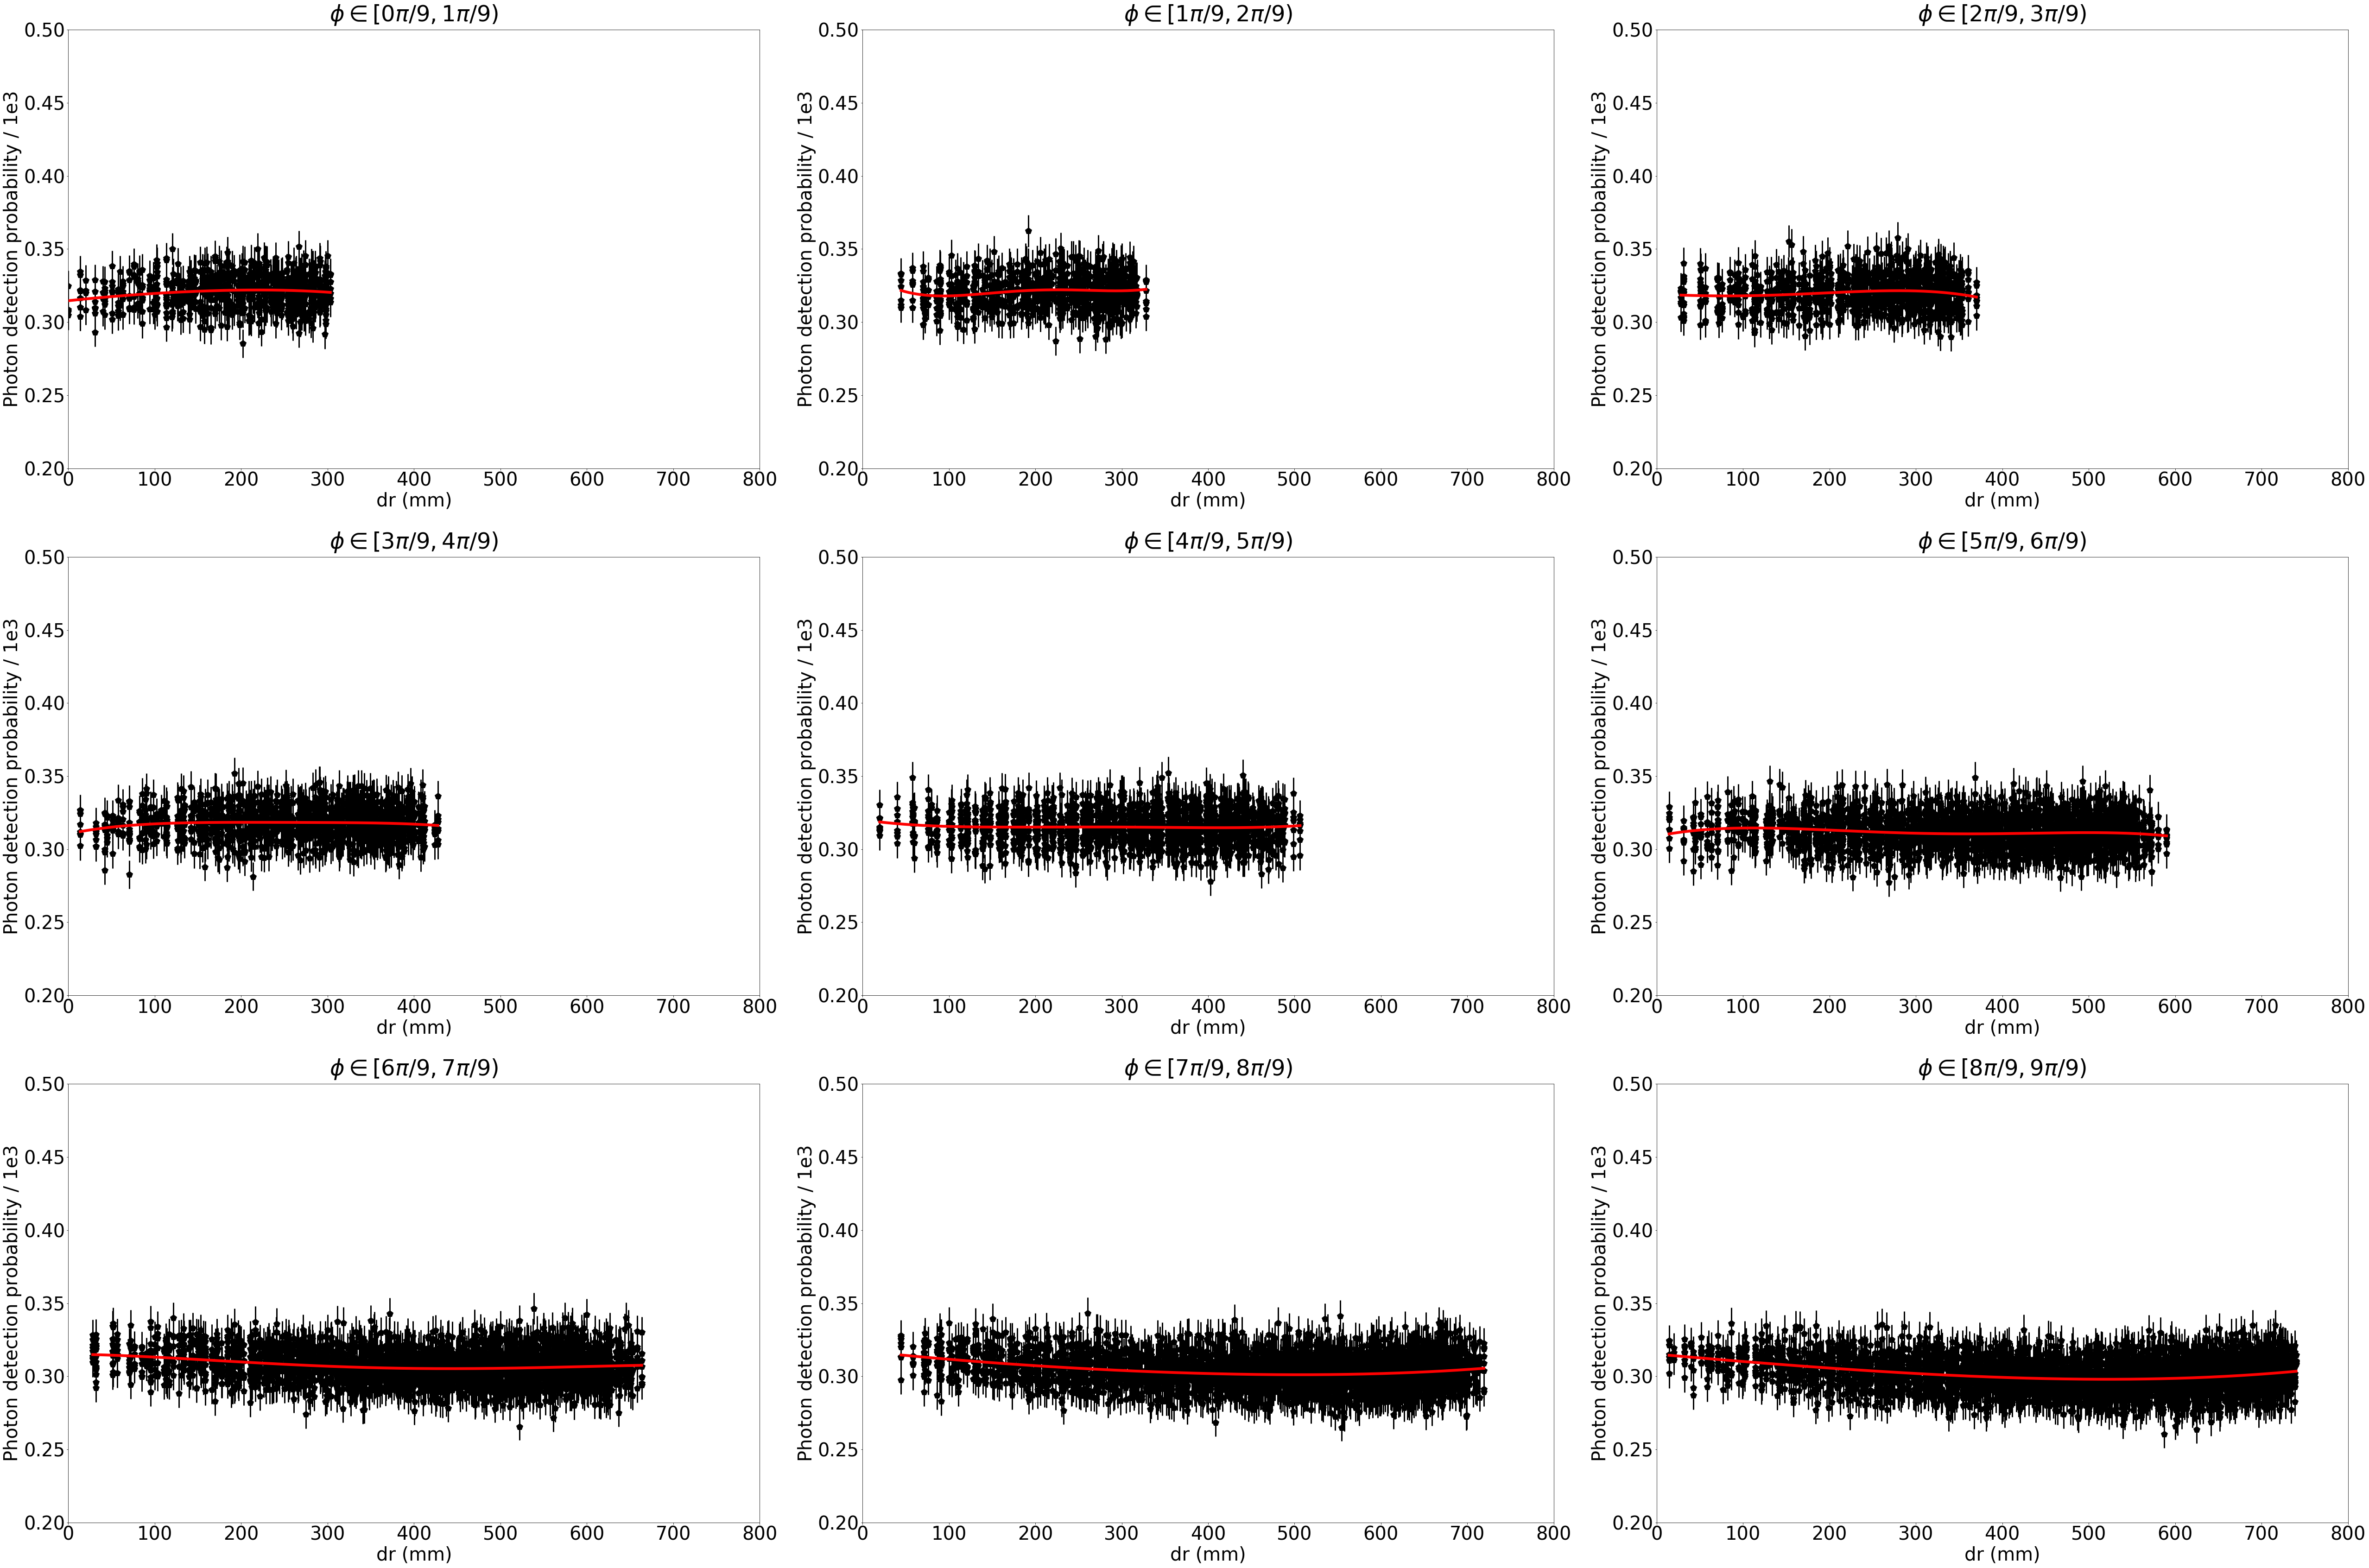

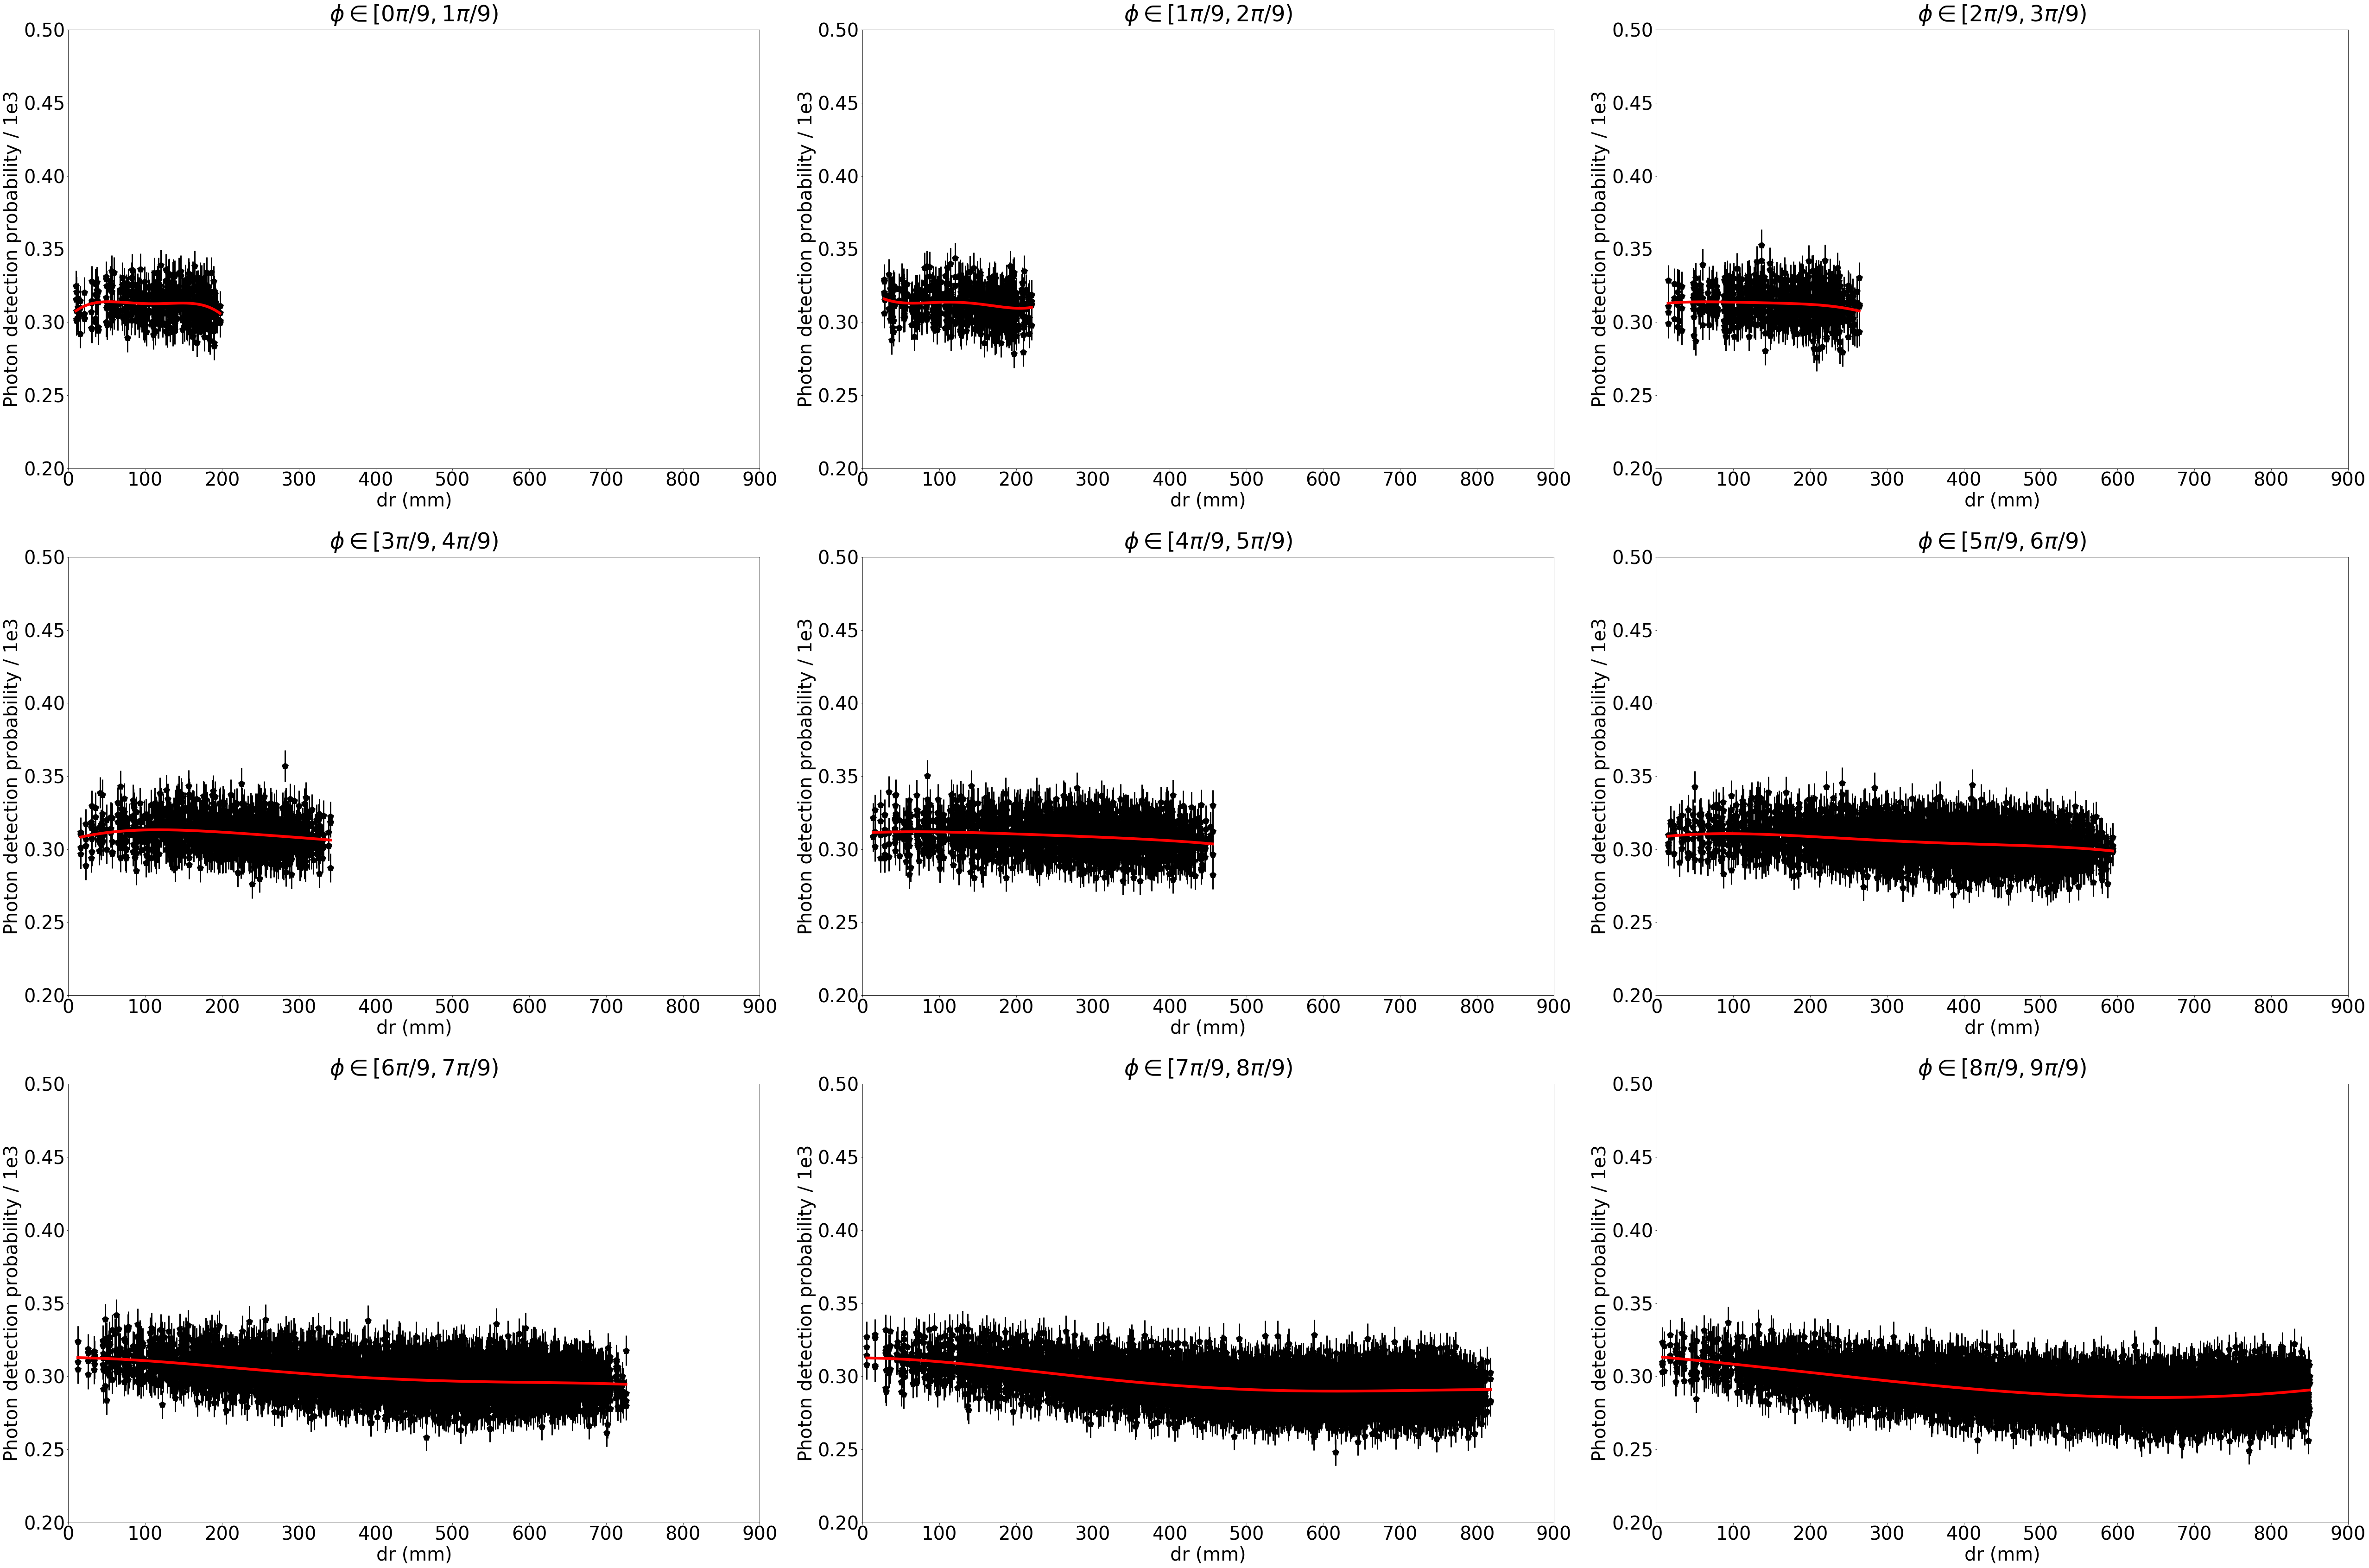

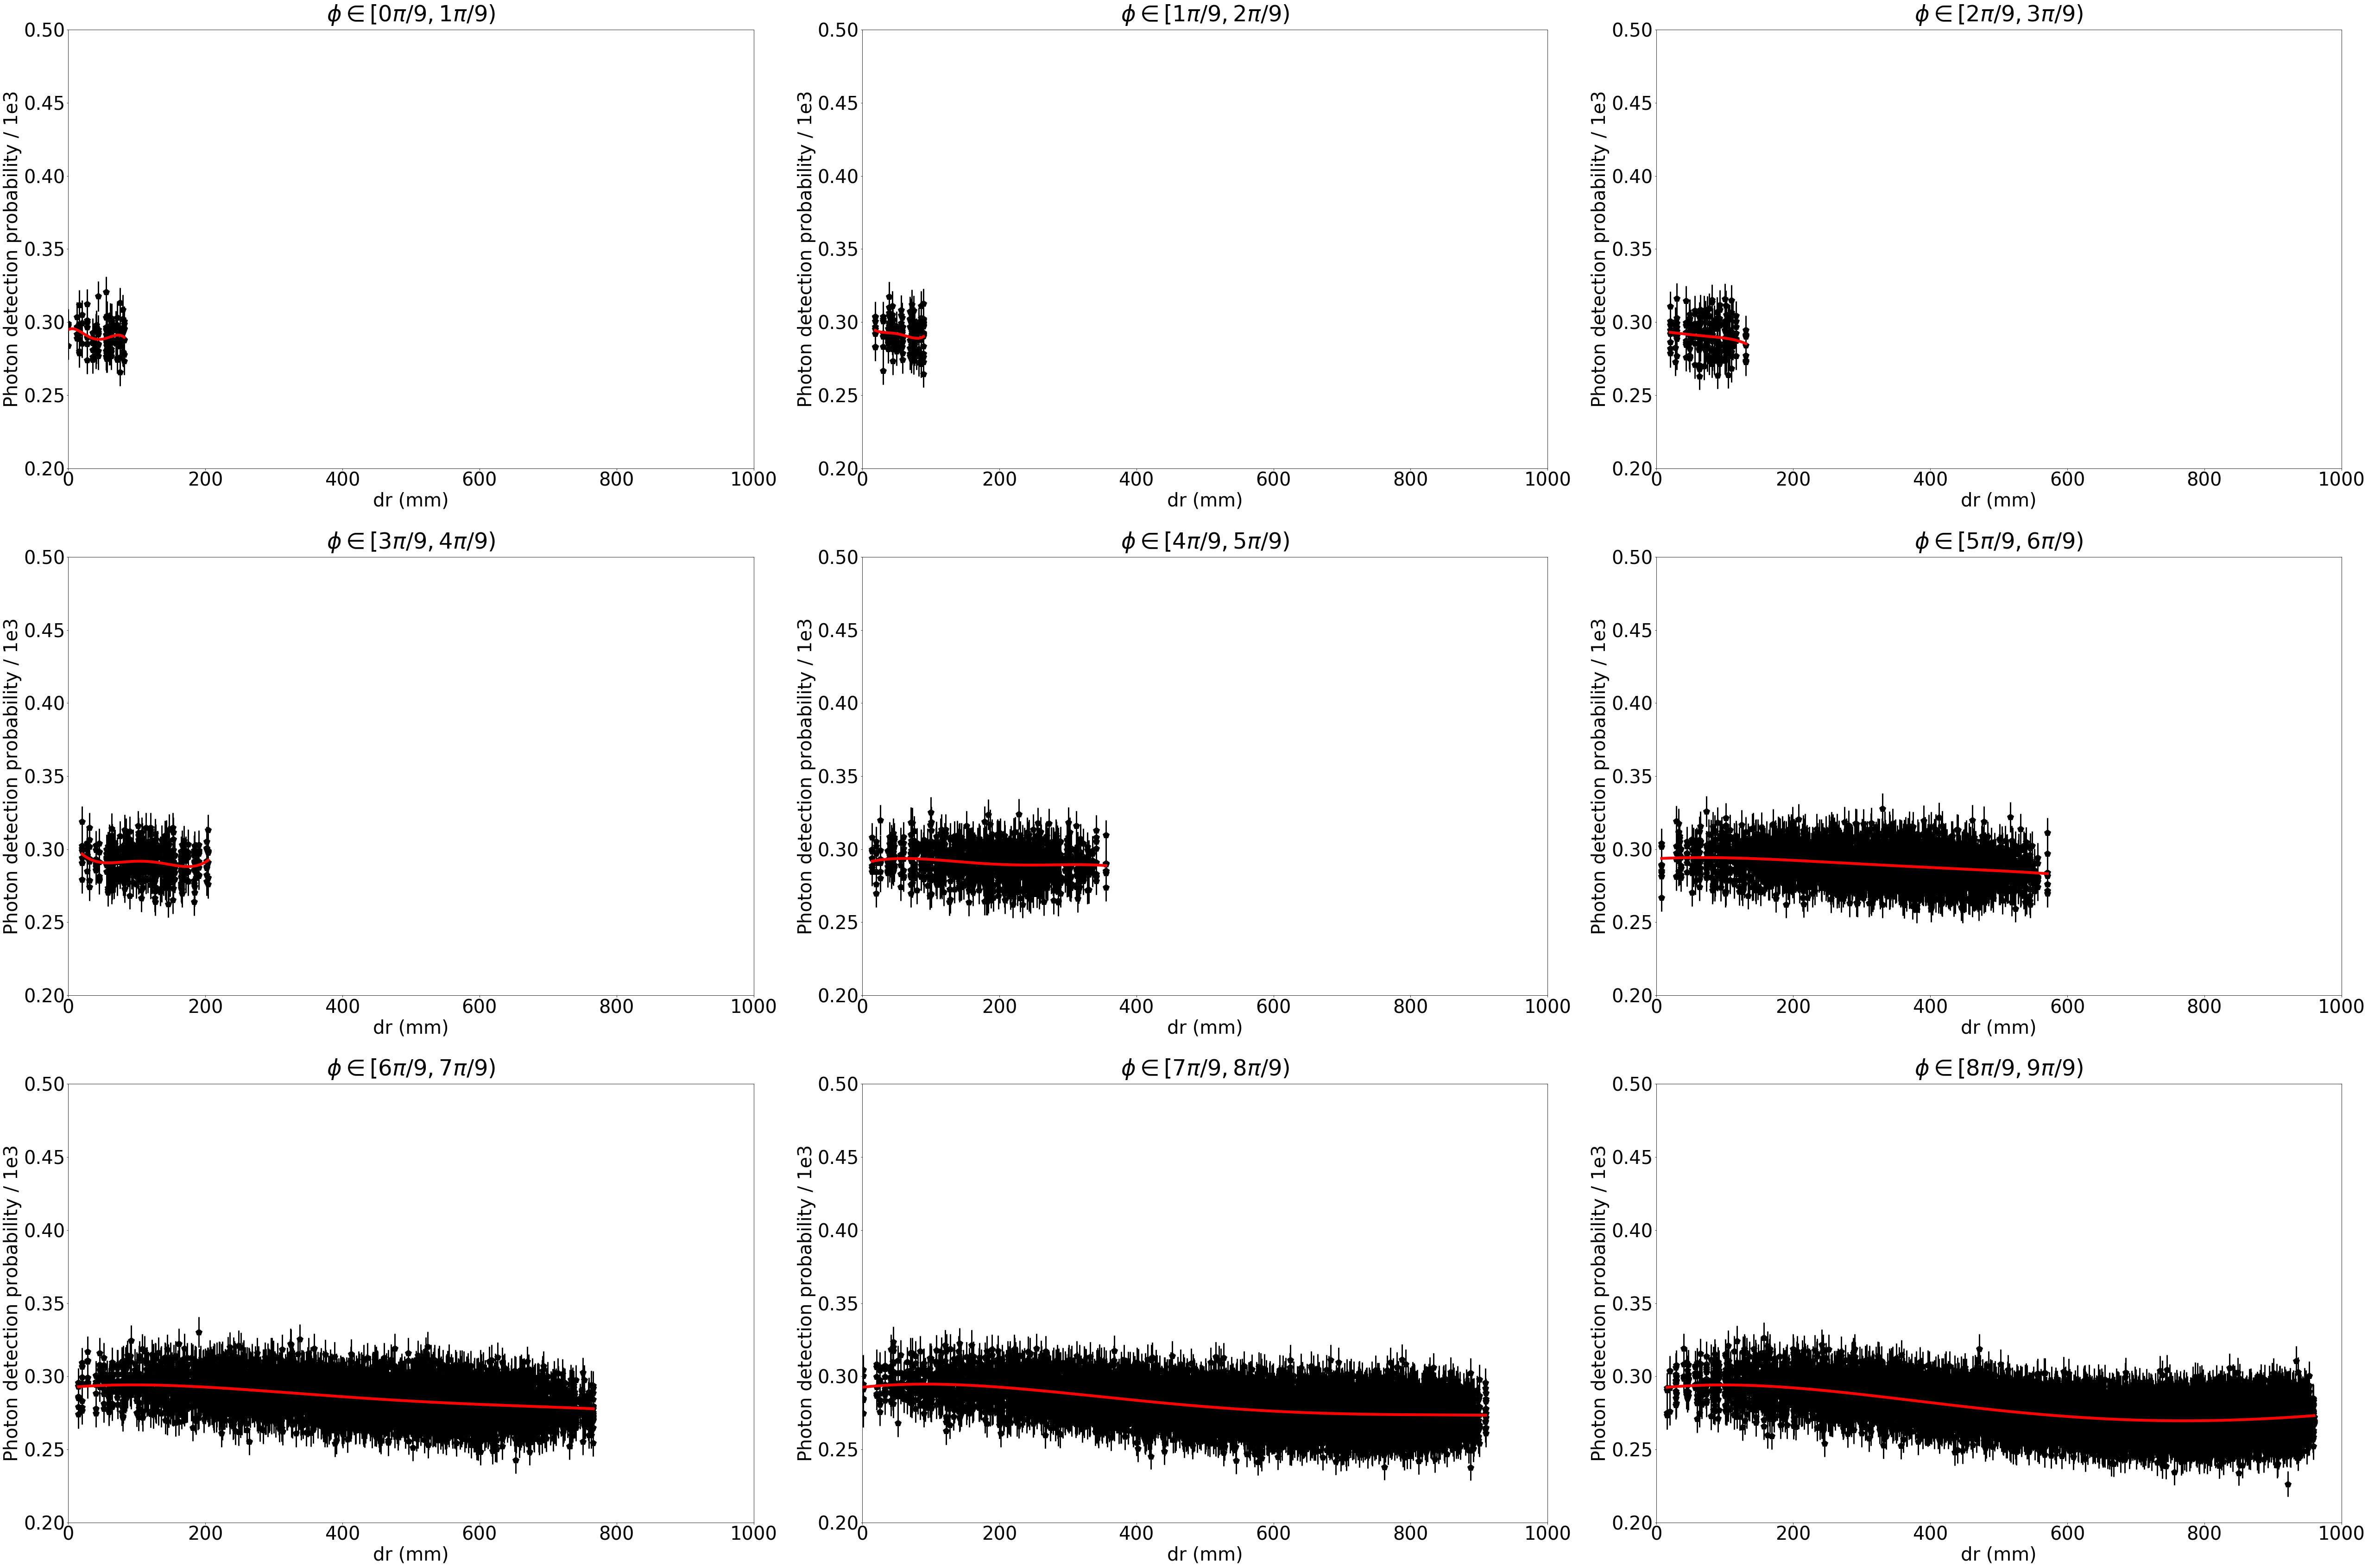

In [76]:
def build_dr_fun(df):
    def param(dr):
        return sum(row.value * dr**row.dr_coeff for _, row in df.iterrows())
    return param


zval = 500
ymin = 0.2
for ring, xmax in enumerate((700, 800, 900, 1000)):
    scalestr = "1e3"
    scale    = float(scalestr)

    plt.figure(figsize=(72, 48))
    for dphi in range(n_phi_sectors):
        drd = dr_data[((dr_data.ring == ring) & 
                       (dr_data.z    == zval) &
                       (dr_data.dphi == dphi)  )]
        drf = dr_fit [((dr_fit .ring == ring) & 
                       (dr_fit .z    == zval) &
                       (dr_fit .dphi == dphi)  )]

        plt.subplot (3, 3, dphi + 1)
        plt.errorbar(drd.dr, drd.prob * scale, drd.uncert * scale, fmt="pk", zorder=1)
        plt.xlim(   0, xmax)
        plt.ylim(ymin, 0.5)

        x = np.linspace(drd.dr.min(), drd.dr.max(), 201)
        y = build_dr_fun(drf)(x) * scale
        plt.plot(x, y, "r-", lw=6, zorder=2)

        plt.title(f"$\phi \in [{dphi}\pi/{n_phi_sectors}, {dphi + 1}\pi/{n_phi_sectors})$", fontdict={"verticalalignment":"bottom"})
        plt.xlabel("dr (mm)")
        plt.ylabel(f"Photon detection probability / {scalestr}")

    plt.tight_layout()
    save(f"next100_s1_dr_ring{ring}_z_{zval}.png")

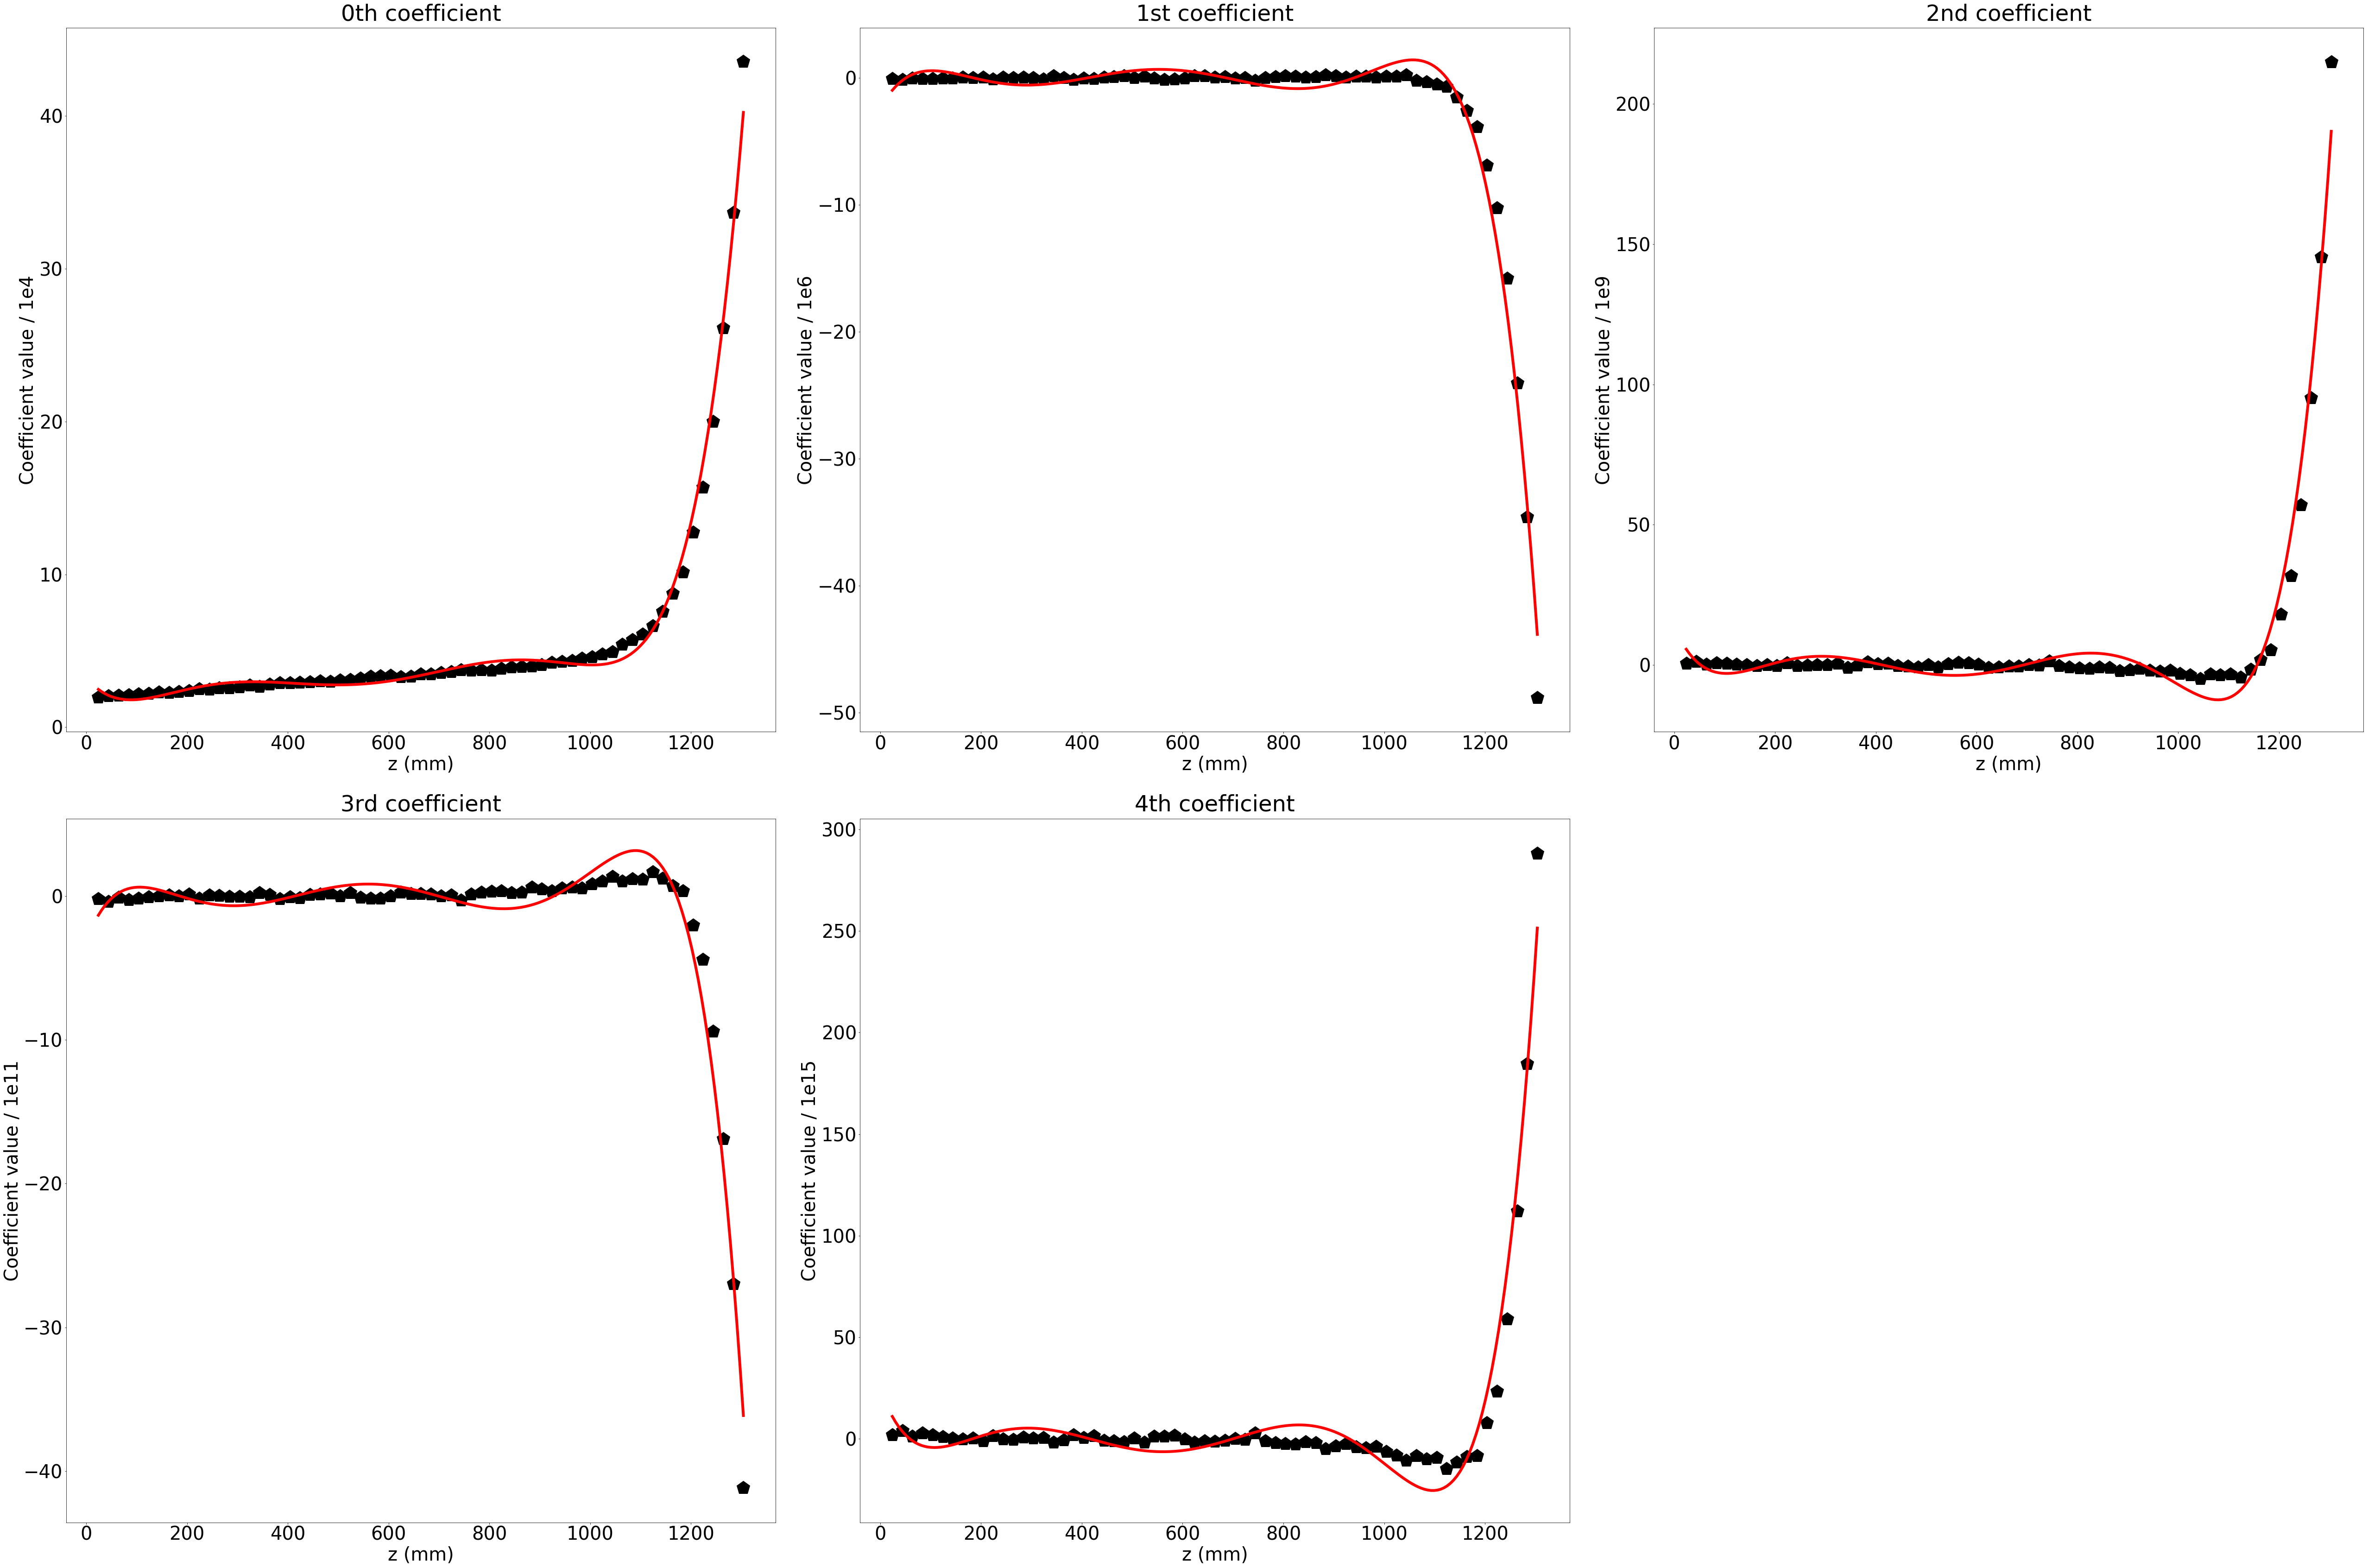

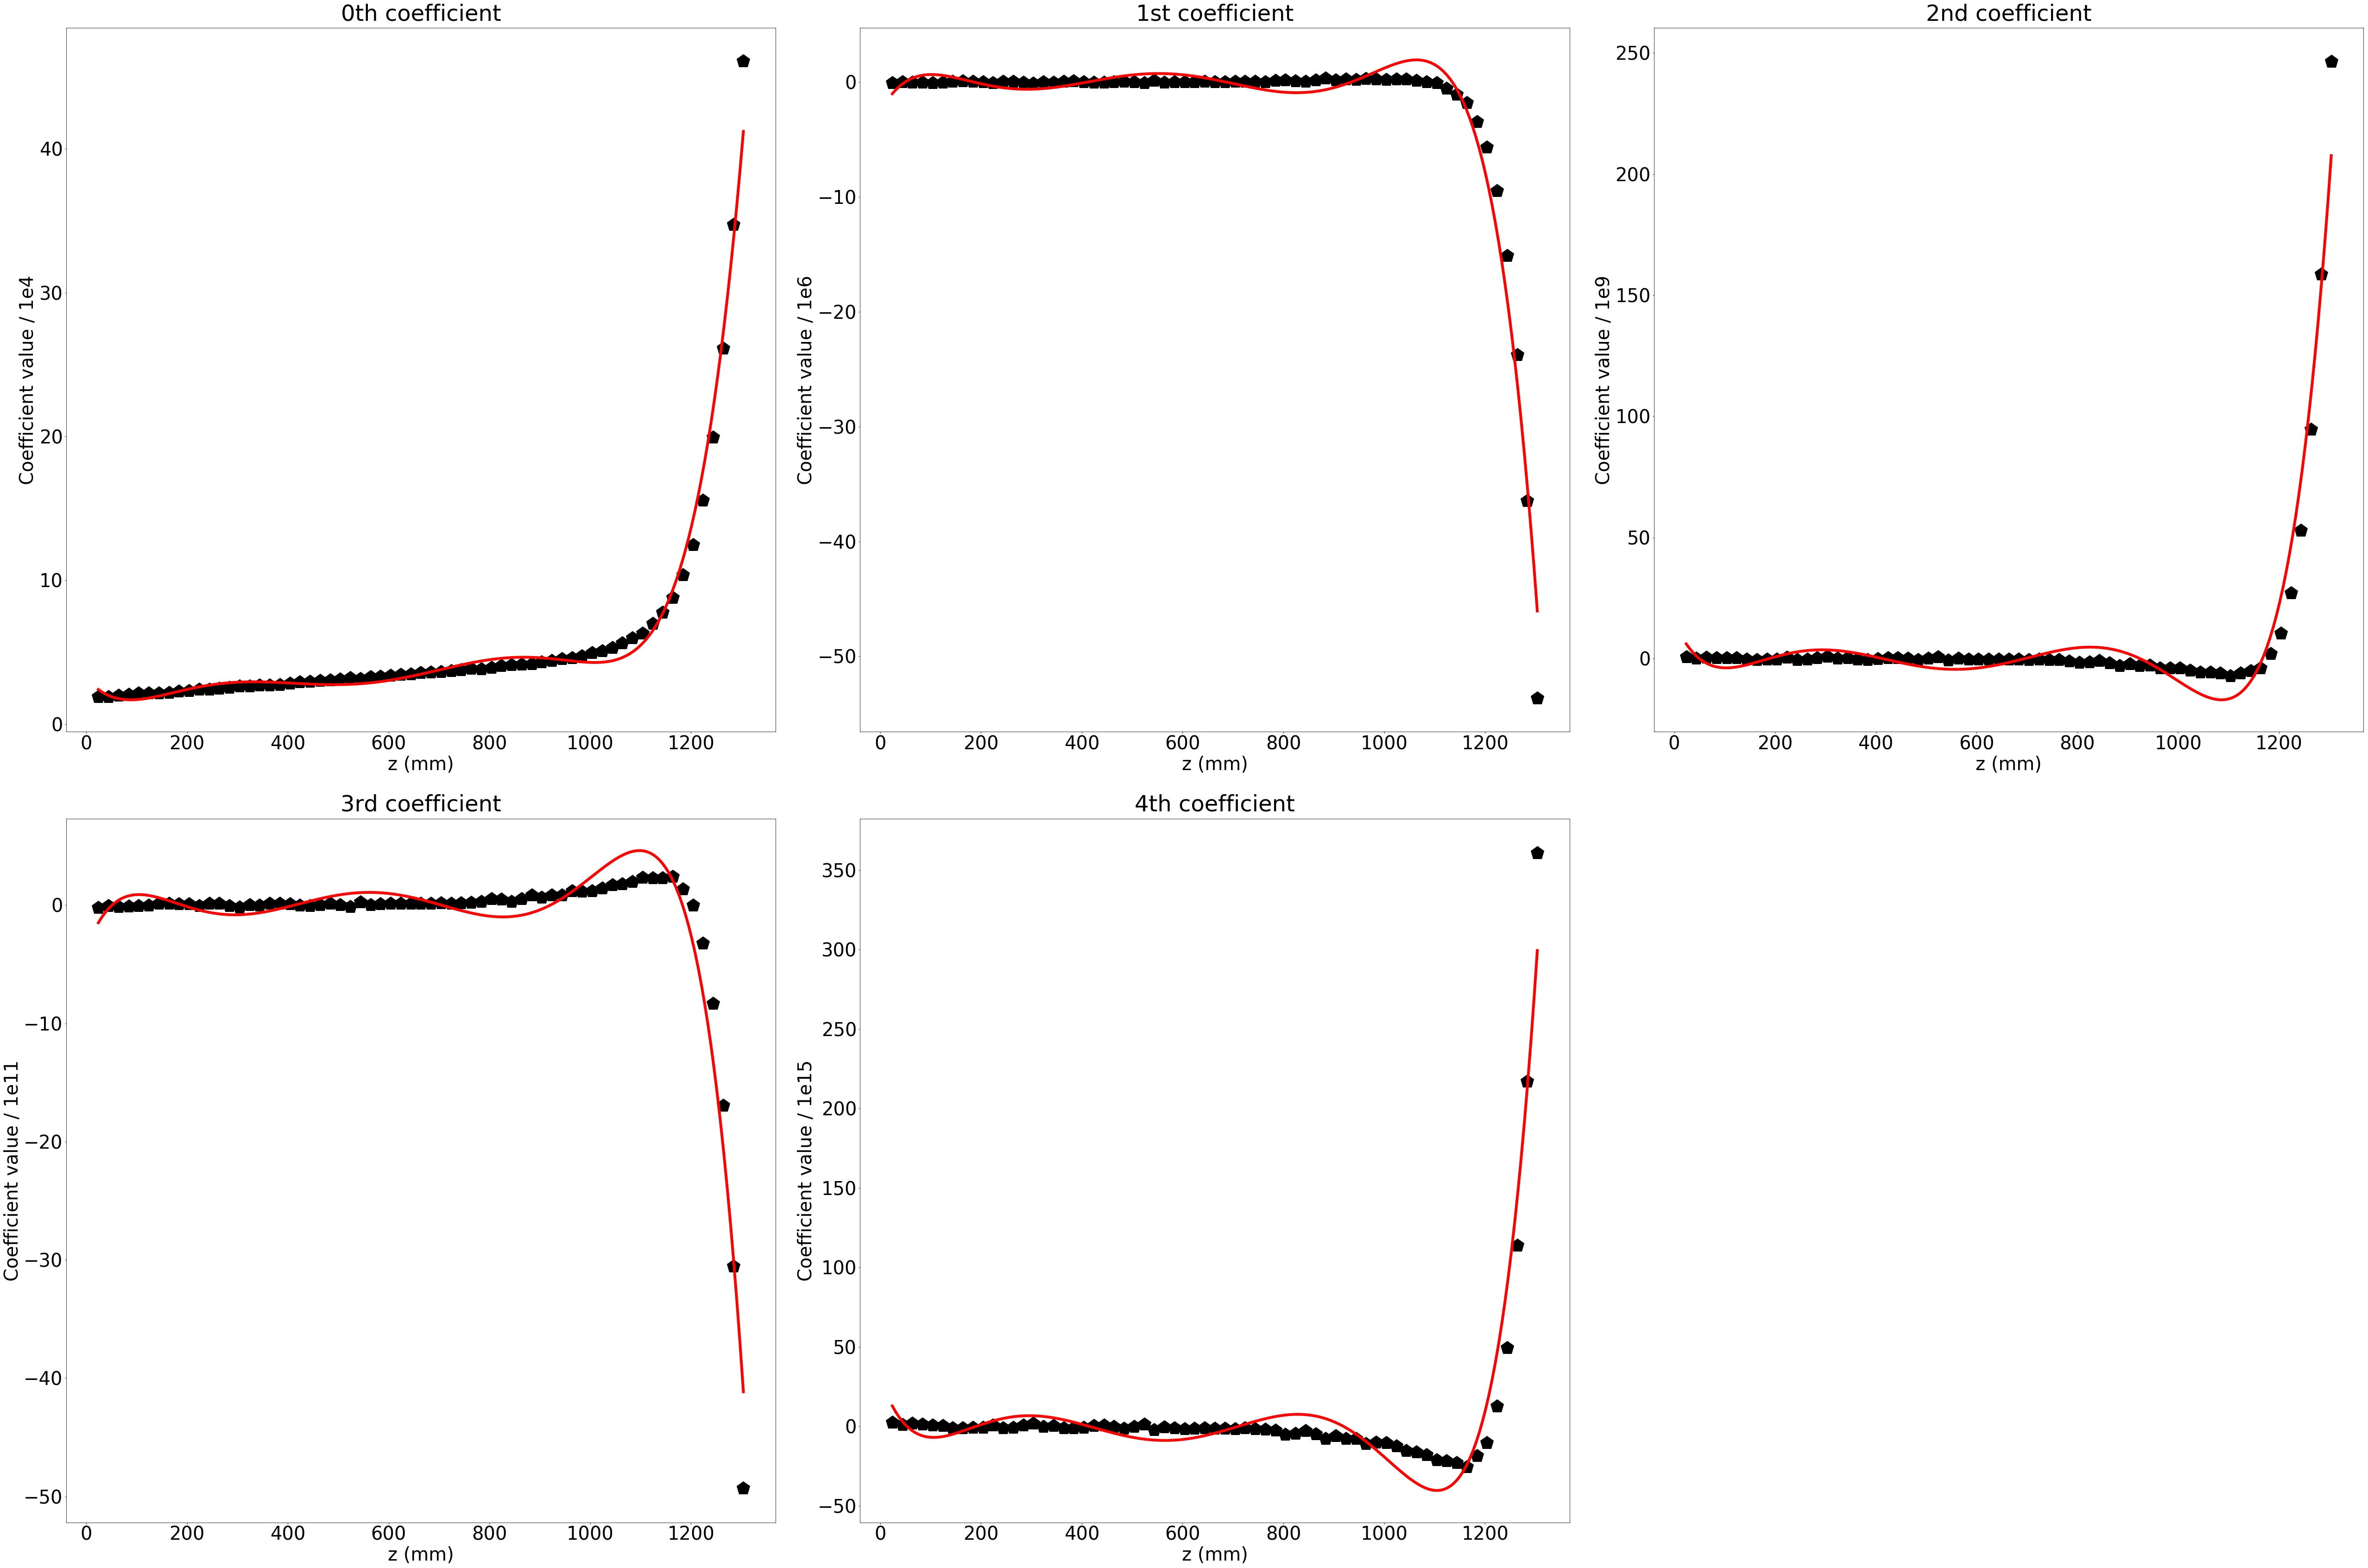

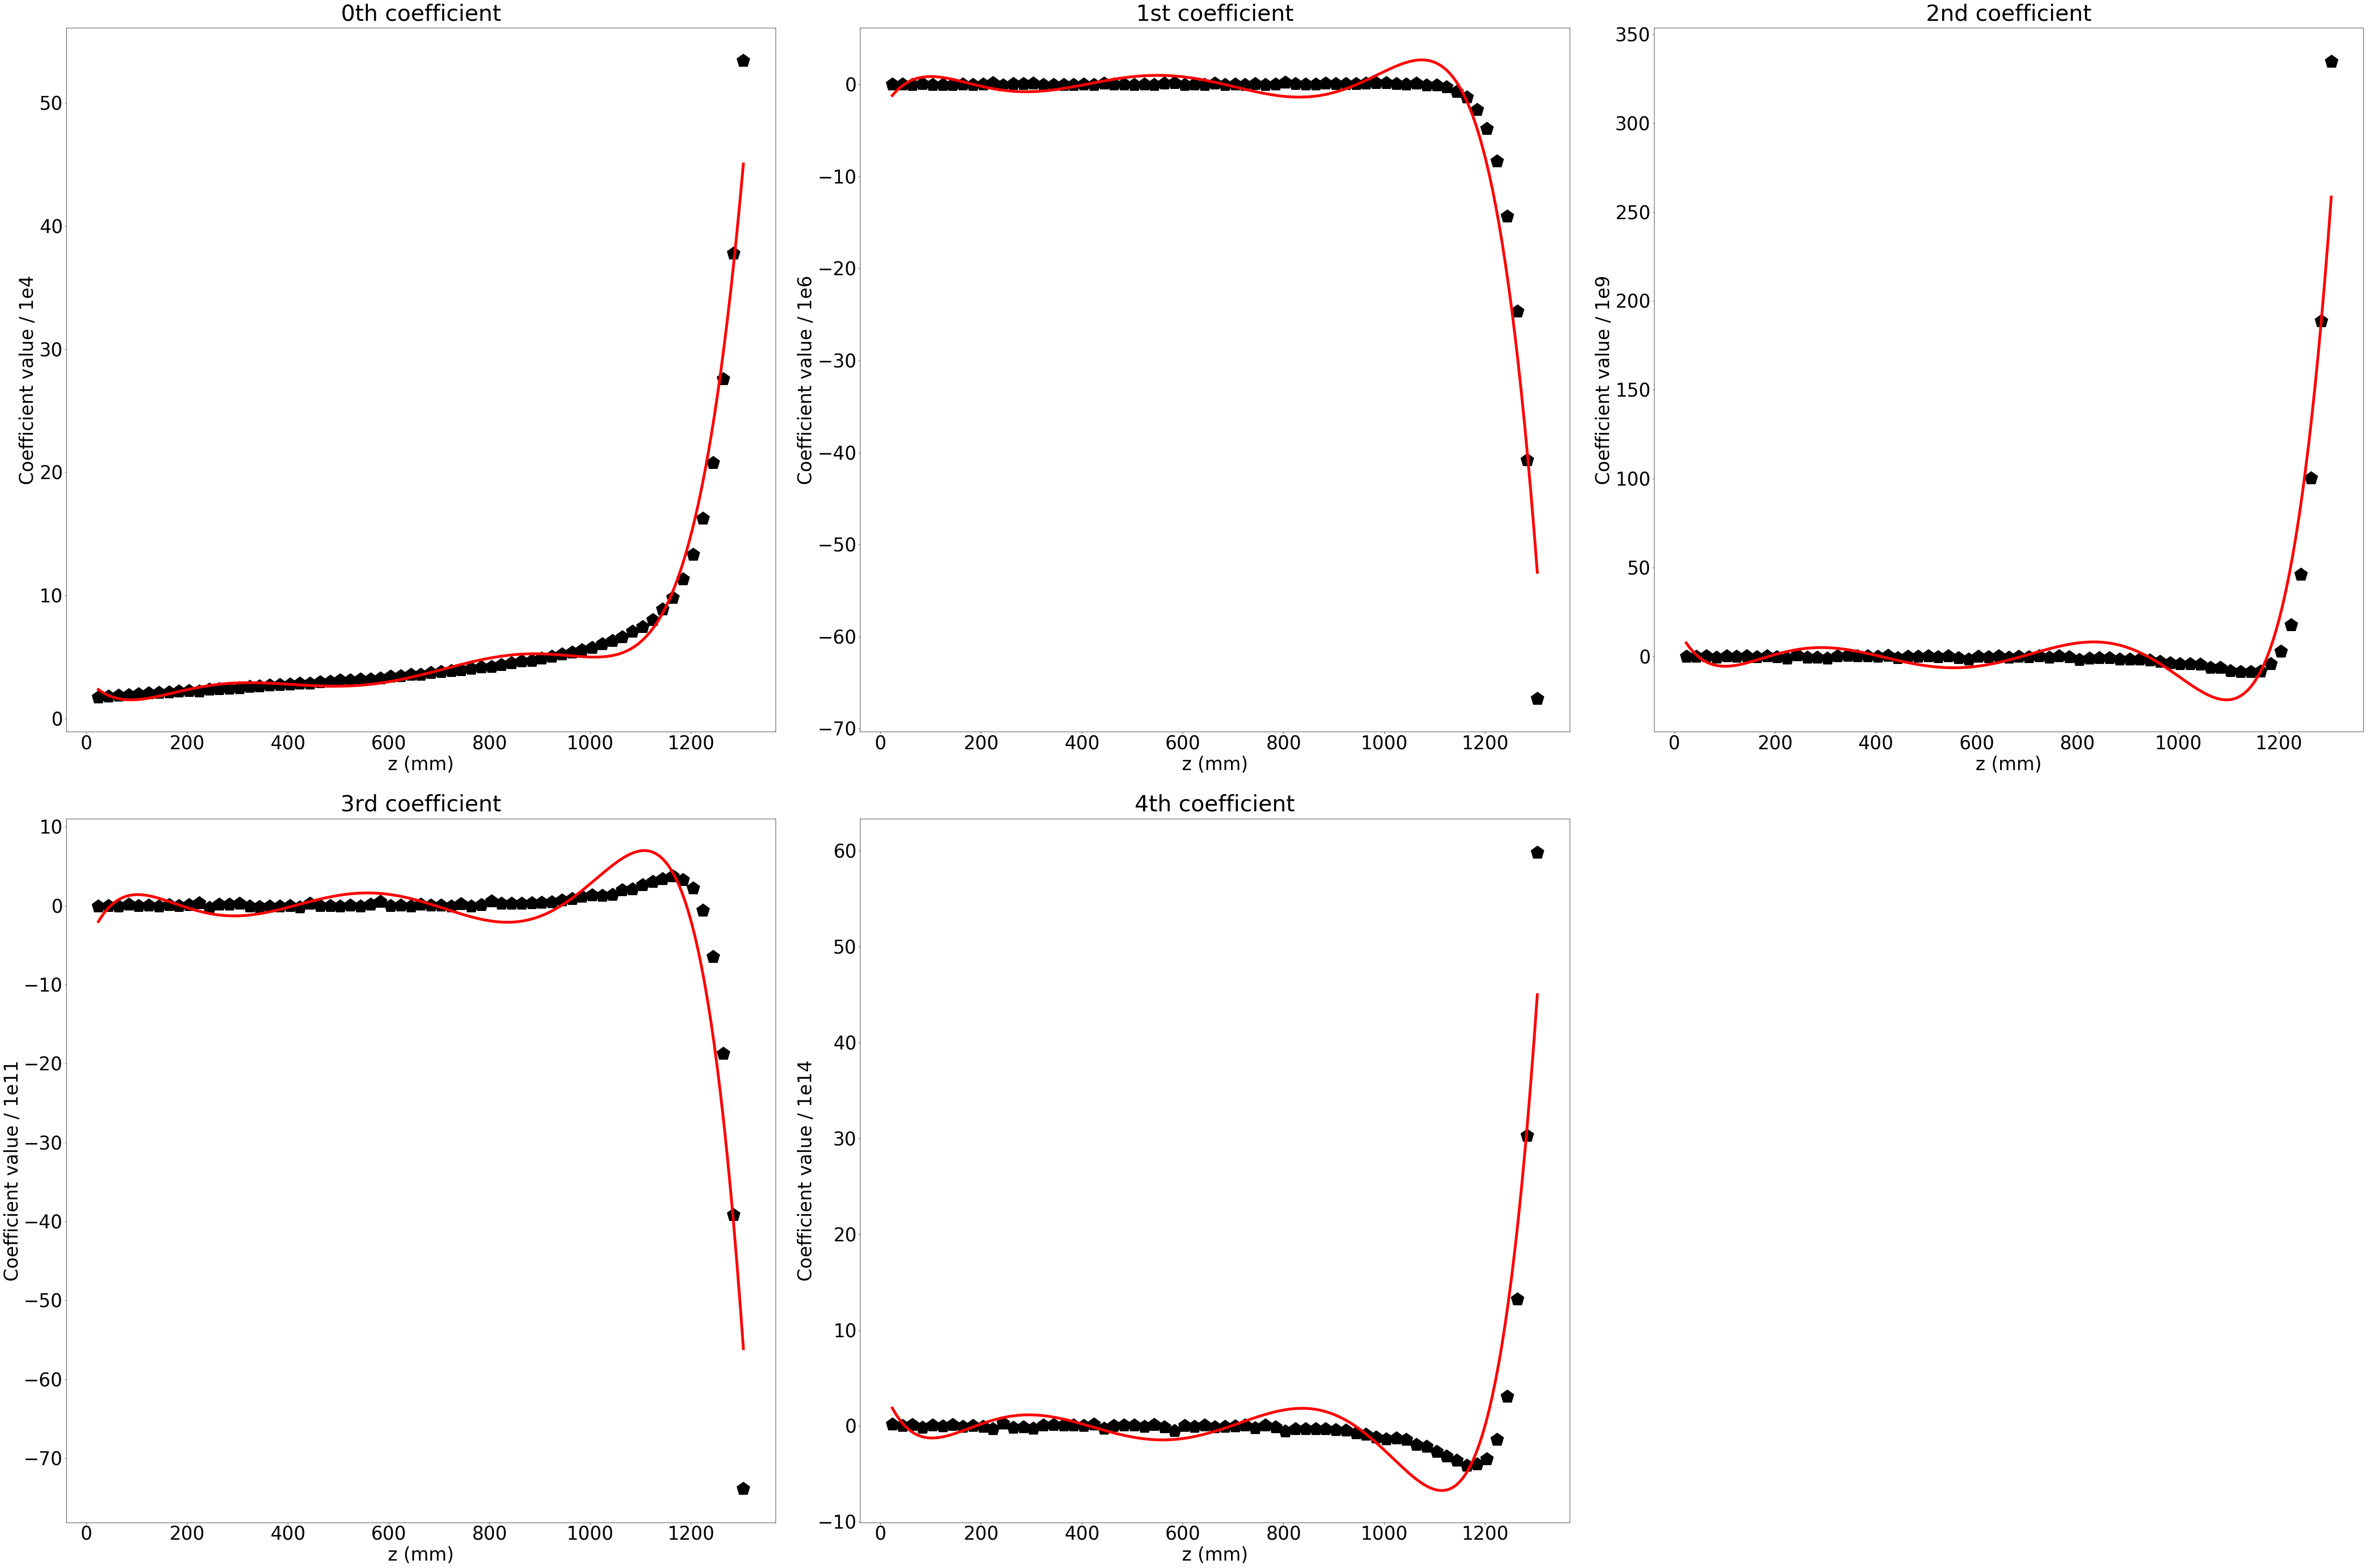

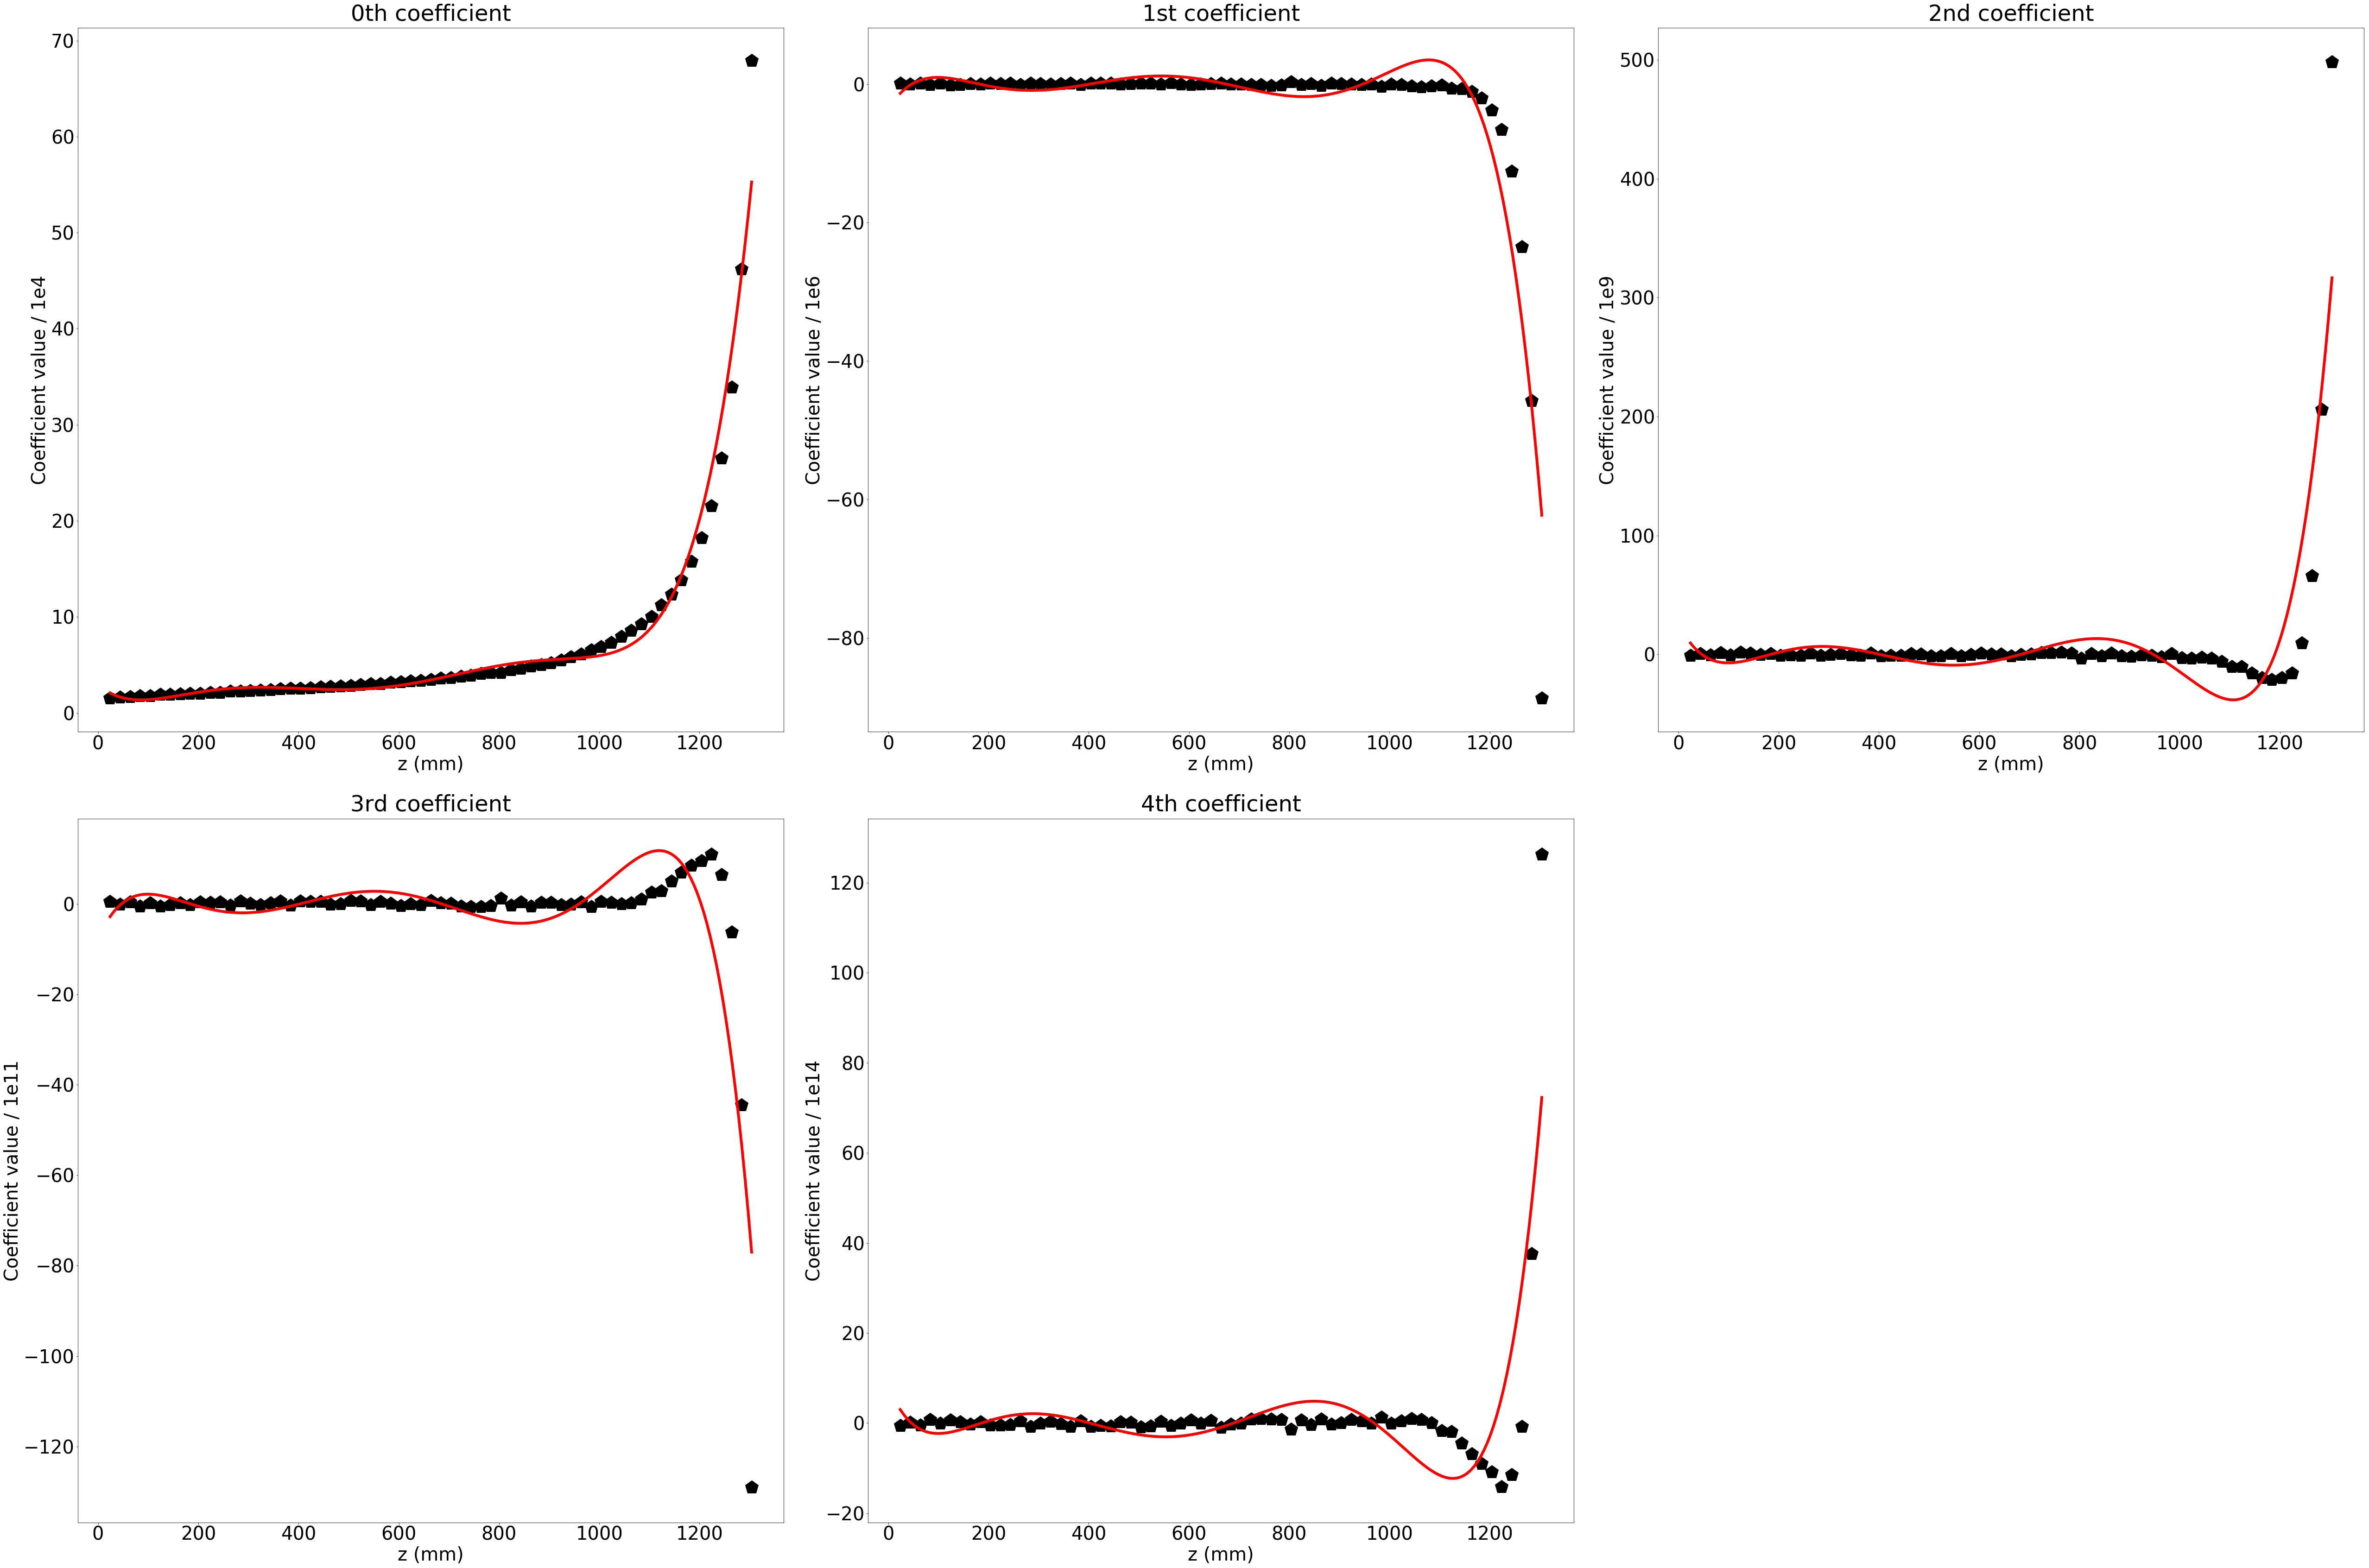

In [83]:
def build_z_fun(df):
    def param(z):
        return sum(row.value * z**row.z_coeff for _, row in df.iterrows())
    return param


dphi = 4
for ring in range(4):
    plt.figure(figsize=(72, 48))
#    plt.figure(figsize=(48, 72))
    for dr_c, pname in enumerate(["0th", "1st", "2nd", "3rd", "4th"]):
        zd = z_data[((z_data.ring     == ring) & 
                     (z_data.dr_coeff == dr_c) &
                     (z_data.dphi     == dphi)  )]
        zf = z_fit [((z_fit .ring     == ring) & 
                     (z_fit .dr_coeff == dr_c) &
                     (z_fit .dphi     == dphi)  )]

        scale = 1/10**np.floor(np.log10(np.abs(np.mean(zd.value))))

        plt.subplot (2, 3, dr_c + 1)
        plt.errorbar(zd.z, zd.value * scale, zd.uncert * scale, fmt="pk", zorder=1, markersize=30)
        x = np.linspace(zd.z.min(), zd.z.max(), 201)
        y = build_z_fun(zf)(x) * scale
        plt.plot(x, y, "r-", lw=6, zorder=2)

        plt.title(f"{pname} coefficient", fontdict={"verticalalignment":"bottom"})
        plt.xlabel("z (mm)")
        plt.ylabel(f"Coefficient value / 1e{int(np.log10(scale))}")

    plt.tight_layout()
    save(f"next100_s1_z_ring{ring}_z_dphi_{dphi}.png")

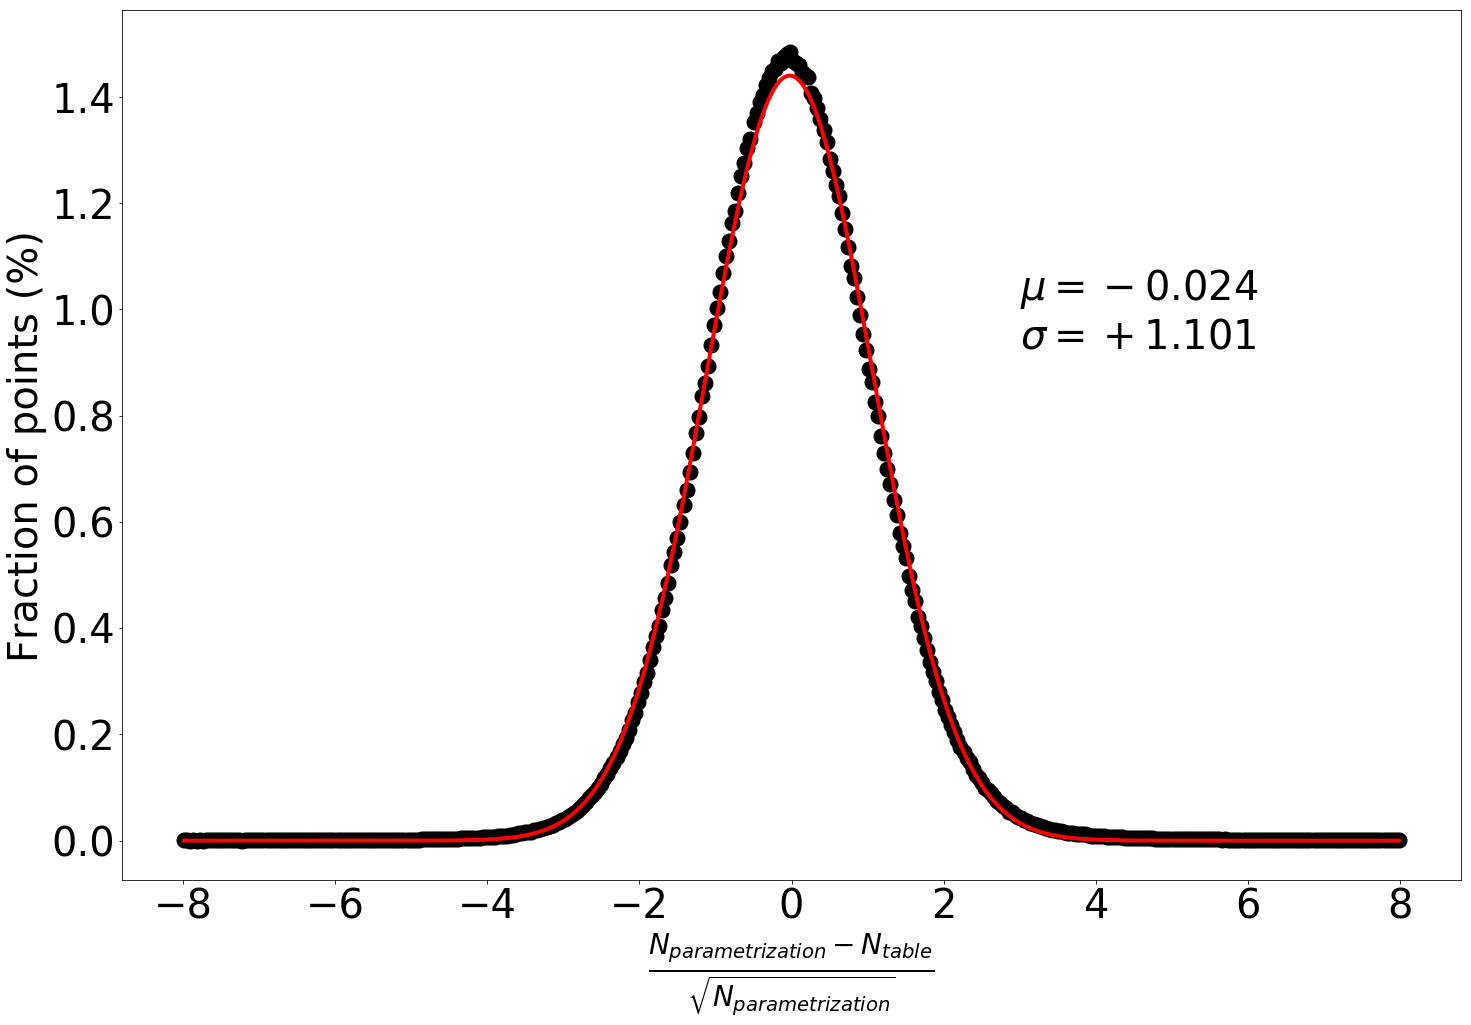

In [84]:
df       = pull_data[pull_data.r.isnull() & pull_data.z.isnull()].drop_duplicates("pull").copy()
total    = df.many.sum() * 0.01
sigma    = np.clip(np.sqrt(df.many), 5, np.inf)
df.many /= total
sigma   /= total
f        = fitf.fit(fitf.gauss, df.pull, df.many, (1, 0, 1),
                    sigma = sigma)

mu  = f"$\mu = {f.values[1]:+.3f} \pm {f.errors[1]:.3f}$"
sig = f"$\sigma = {f.values[2]:+.3f} \pm {f.errors[2]:.3f}$"
mu  = f"$\mu = {f.values[1]:+.3f}$"
sig = f"$\sigma = {f.values[2]:+.3f}$"

plt.errorbar(df.pull, df.many, sigma, np.diff(df.pull)[0]/2, "ok", zorder=1)
plt.plot    (df.pull, f.fn(df.pull), "r-", zorder=2, lw=4)
plt.text    (3, np.mean(plt.ylim()) * 1.25, "\n".join([mu, sig]))

pulldef = r"$\frac{N_{parametrization} - N_{table}}{\sqrt{N_{parametrization}}}$"
plt.xlabel(pulldef)
plt.ylabel("Fraction of points (%)")

save("next100_s1_pull.png")